# Let's make some nice looking fig.1 in this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sal.utils.math import (
    find_majority_answer, extract_completion_answers,
    memoized_canonical_form, find_answer_with_largest_sum,
    strip_string
)

from tqdm import tqdm
from datasets import Dataset, load_dataset

dataset_name = "HuggingFaceH4/MATH-500"
dataset_split = "test"
dataset = load_dataset(dataset_name, split=dataset_split)
gt_answers = [
    row['answer']
    for row in dataset
]

In [289]:
import boto3
import json
def download_and_load_json(full_path, local_path):
    file_dir = full_path
    bucket_name, key = file_dir.replace('s3://', '').split('/', 1)
    s3 = boto3.client('s3')
    # Remove local_path if it exists
    try:
        os.remove(local_path)
    except OSError:
        pass
    try:
        s3.download_file(bucket_name, key, local_path)
    except Exception as e:
        print(f"Error downloading file: {e}")
        print(key)

    # print(f"File downloaded to {local_path}")
    model_responses = []
    with open(local_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        return data

all_answers = []
folder_name = 'dpsk_new_sample_long_with_final_answer'
all_seeds = range(8)
qid = 18
save_name = 'hello_fun_fun'

for seed in all_seeds:
    # file_dir = f's3://netflix-dataoven-prod-users/xiw/dpsk_math_eval/dpsk_new_det_with_final_answer/seed_{seed}/answers_{qid}.json'
    file_dir = f's3://netflix-dataoven-prod-users/xiw/dpsk_math_eval/{folder_name}/seed_{seed}/answers_{qid}.json'
    F = download_and_load_json(file_dir, f'/tmp/answers_{save_name}.json')
    all_answers.append(F)

In [2]:
def load_log(QID):
    tmp_dir = '/root/tts_and_entropy/outputs/cached_results'
    entropy_base_dir = '/root/tts_and_entropy/outputs/entropy_log_math'
    ANS = np.load(
        os.path.join(tmp_dir, f'all_extracted_answers_{QID}.npy')
    )

    ACC = np.load(
        os.path.join(tmp_dir, f'all_accs_{QID}.npy')
    )

    ENTROPY = np.load(
        os.path.join(entropy_base_dir, f'entropy_{QID}_new.npy')
    )

    no_thinking_entropy = np.load(
        os.path.join(entropy_base_dir, 'entropy_no_thinking.npy')
    )[QID]

    ua = []
    for _A in ANS:
        ua.append(len(np.unique(_A)))
    
    return ANS, np.array(ua), ACC, ENTROPY, no_thinking_entropy


def load_log(QID, acc_dir, entropy_dir, entropy_pattern, include_ans=False):
    tmp_dir = acc_dir
    entropy_base_dir = entropy_dir

    ACC = np.load(
        os.path.join(tmp_dir, f'all_accs_{QID}.npy')
    )

    ENTROPY = np.load(
        os.path.join(entropy_base_dir, entropy_pattern.format(QID))
    )

    if include_ans:
        ANS = np.load(
            os.path.join(tmp_dir, f'all_extracted_answers_{QID}.npy')
        )
        ua = []
        for _A in ANS:
            ua.append(len(np.unique(_A)))
        return ACC, ENTROPY, np.array(ua), ANS
    
    return ACC, ENTROPY

In [19]:
save_dir = f'./math_outputs'

model_solutions_dir = "/root/tts_and_entropy/model_solutions/dpsk_new_no_sample.json"
# model_solutions_dir = "/root/tts_and_entropy/model_solutions/dpsk_new_with_sample.json"
model_solutions = []
with open(model_solutions_dir, 'r') as f:
    for line in f:
        if line.strip():
            model_solutions.append(json.loads(line.strip()))

model_solutions_dir = '/root/tts_and_entropy/model_solutions/dpsk_new_long.json'
model_solutions_dpsk_long = []
with open(model_solutions_dir, 'r') as f:
    for line in f:
        if line.strip():
            model_solutions_dpsk_long.append(json.loads(line.strip()))


model_solutions_dir = '/root/tts_and_entropy/model_solutions/dpsk_new_with_sample_long.json'
model_solutions_dpsk_long_with_sample = []
with open(model_solutions_dir, 'r') as f:
    for line in f:
        if line.strip():
            model_solutions_dpsk_long_with_sample.append(json.loads(line.strip()))


save_dir = f'./math_outputs'

model_solutions_dir = "/root/tts_and_entropy/model_solutions/qwen_new_with_sample_long.json"
# model_solutions_dir = "/root/tts_and_entropy/model_solutions/dpsk_new_with_sample.json"
model_solutions_qwen = []
with open(model_solutions_dir, 'r') as f:
    for line in f:
        if line.strip():
            model_solutions_qwen.append(json.loads(line.strip()))

Text(1.8, 0.2, 'One forward\npass')

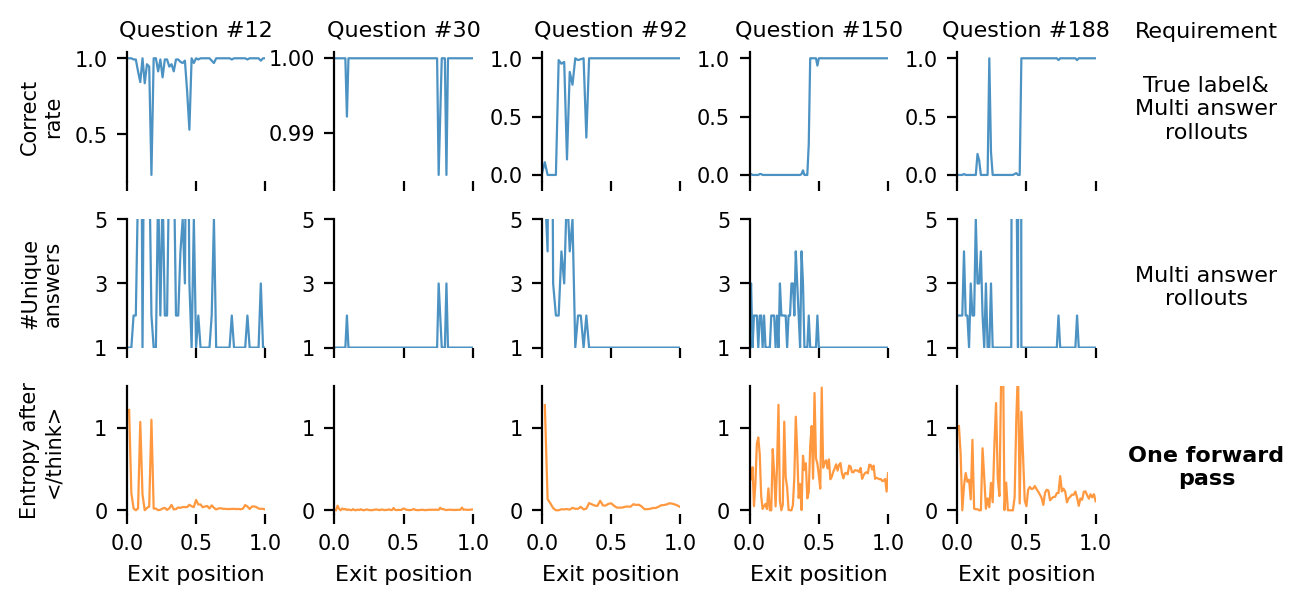

In [281]:
from matplotlib import cm
my_colors = cm.tab10([0,1,2,3])


QIDS = [
    12, 30, 92, 150, 188
]

fig, ax = plt.subplots(3, len(QIDS), figsize=(6.25, 3.0), sharex='col')
fig.subplots_adjust(wspace=0.5, hspace=0.3)
line_config = {
    'linewidth': 0.8,
    'alpha': 0.8,
}

# acc_dir = '/root/tts_and_entropy/outputs/cached_results_qwen_no_sample'
acc_dir = '/root/tts_and_entropy/outputs/cached_results_qwen_long_use_sample'
entropy_dir = '/root/tts_and_entropy/outputs/entropy_log_math'

for i, a in enumerate(ax[0]):
    a.set_title(f'Question #{QIDS[i]}', fontsize=8)

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.tick_params(labelsize=7.5, axis='both')

for a in ax[-1]:
    a.set_xlabel('Exit position', fontsize=8)
    a.set_xticks([0.0, 0.5, 1.0])
    a.set_xlim(0, 1.0)

for i, qid in enumerate(QIDS):
    acc, ent, ua, ans = load_log(
            qid,
            acc_dir,
            entropy_dir,
            # 'entropy_{}_new_qwen_new.npy',
            'entropy_{}_new_qwen_new_with_sample_ngram.npy',
            # 'entropy_{}_new_qwen_new_with_sample_ngram_with_final_answer_str.npy',
            include_ans=True
        )

    X = np.arange(len(acc)) / (len(acc) - 1)

    ax[0, i].plot(X, acc, **line_config)
    ENT = ent[:, 1]
    ax[2, i].plot(X[1:], ENT, label='unigram',
                  c=my_colors[1],
                   **line_config)
    ax[1, i].plot(X, ua, **line_config)


    if i == 0:
        ax[0, 0].set_ylabel('Correct\nrate', fontsize=7.5)
        ax[2, 0].set_ylabel('Entropy after\n</think>', fontsize=7.5)
        ax[1, 0].set_ylabel('#Unique\nanswers', fontsize=7.5)

ax[2, 0].set_ylim(-0.05, 1.5)
ax[2, 1].set_ylim(-0.05, 1.5)
ax[2, 2].set_ylim(-0.05, 1.5)
ax[2, 3].set_ylim(-0.05, 1.5)
ax[2, 4].set_ylim(-0.05, 1.5)
fig.align_ylabels(ax[:, 0])

for a in ax[1]:
    a.set_ylim(1, 5)
    a.set_yticks([1, 3, 5])

ax[0, -1].text(
    1.8, 1.08, 'Requirement',
    transform=ax[0, -1].transAxes,
    ha='center', va='bottom', fontsize=8
)

ax[0, -1].text(
    1.8, 0.3, 'True label&\nMulti answer\nrollouts',
    transform=ax[0, -1].transAxes,
    ha='center', va='bottom', fontsize=8
)


ax[1, -1].text(
    1.8, 0.3, 'Multi answer\nrollouts',
    transform=ax[1, -1].transAxes,
    ha='center', va='bottom', fontsize=8
)

ax[2, -1].text(
    1.8, 0.2, 'One forward\npass',
    transform=ax[2, -1].transAxes,
    ha='center', va='bottom', fontsize=8,
    fontweight='bold'
)

# fig.savefig(
#     '/root/figures/math_qwen_long_with_sample_big_three_rows.pdf',
#     bbox_inches='tight',
# )

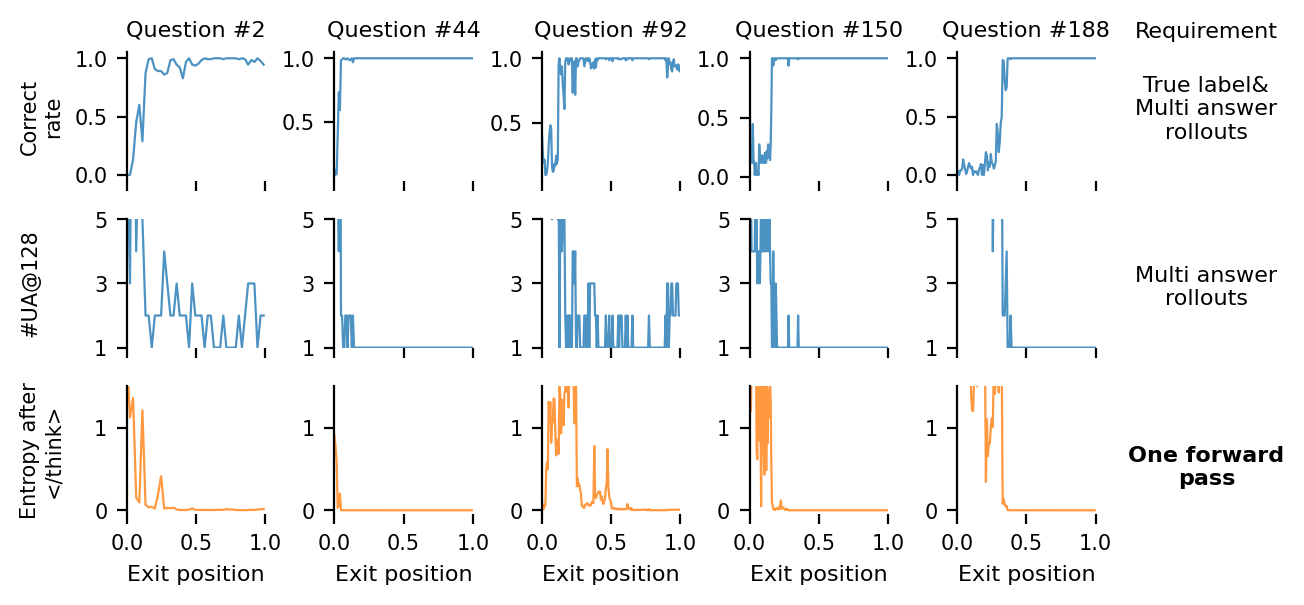

In [ ]:
# DPSK, long with sample, figure 1

from matplotlib import cm
my_colors = cm.tab10([0,1,2,3])


QIDS = [
    2, 44, 92, 150, 188
]

fig, ax = plt.subplots(3, len(QIDS), figsize=(6.25, 3.0), sharex='col')
fig.subplots_adjust(wspace=0.5, hspace=0.3)
line_config = {
    'linewidth': 0.8,
    'alpha': 0.8,
}

acc_dir = '/root/tts_and_entropy/outputs/cached_results_dpsk_long_use_sample'
entropy_dir = '/root/tts_and_entropy/outputs/entropy_log_math'

for i, a in enumerate(ax[0]):
    a.set_title(f'Question #{QIDS[i]}', fontsize=8)

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.tick_params(labelsize=7.5, axis='both')

for a in ax[-1]:
    a.set_xlabel('Exit position', fontsize=8)
    a.set_xticks([0.0, 0.5, 1.0])
    a.set_xlim(0, 1.0)

for i, qid in enumerate(QIDS):
    acc, ent, ua, ans = load_log(
            qid,
            acc_dir,
            entropy_dir,
            'entropy_{}_new_dpsk_new_with_sample_ngram_with_final_answer_str.npy',
            include_ans=True
        )

    X = np.arange(len(acc)) / (len(acc) - 1)

    ax[0, i].plot(X[::2], acc[::2], **line_config)
    ENT = ent[:, 1][::2]
    ax[2, i].plot(X[:-1][::2], ENT, label='unigram',
                  c=my_colors[1],
                   **line_config)
    ax[1, i].plot(X[::2], ua[::2], **line_config)


    if i == 0:
        ax[0, 0].set_ylabel('Correct\nrate', fontsize=7.5)
        ax[2, 0].set_ylabel('Entropy after\n</think>', fontsize=7.5)
        # ax[1, 0].set_ylabel('#Unique\nanswers', fontsize=7.5)
        ax[1, 0].set_ylabel('#UA@128\n', fontsize=7.5)

ax[2, 0].set_ylim(-0.05, 1.5)
ax[2, 1].set_ylim(-0.05, 1.5)
ax[2, 2].set_ylim(-0.05, 1.5)
ax[2, 3].set_ylim(-0.05, 1.5)
ax[2, 4].set_ylim(-0.05, 1.5)
fig.align_ylabels(ax[:, 0])

for a in ax[1]:
    a.set_ylim(1, 5)
    a.set_yticks([1, 3, 5])

ax[0, -1].text(
    1.8, 1.08, 'Requirement',
    transform=ax[0, -1].transAxes,
    ha='center', va='bottom', fontsize=8
)

ax[0, -1].text(
    1.8, 0.3, 'True label&\nMulti answer\nrollouts',
    transform=ax[0, -1].transAxes,
    ha='center', va='bottom', fontsize=8
)


ax[1, -1].text(
    1.8, 0.3, 
    'Multi answer\nrollouts',
    # 'Multi answer\nrollouts',
    transform=ax[1, -1].transAxes,
    ha='center', va='bottom', fontsize=8
)

ax[2, -1].text(
    1.8, 0.2, 'One forward\npass',
    transform=ax[2, -1].transAxes,
    ha='center', va='bottom', fontsize=8,
    fontweight='bold'
)

fig.savefig(
    '/root/figures/math_dpsk_long_with_sample_big_three_rows.pdf',
    bbox_inches='tight',
)


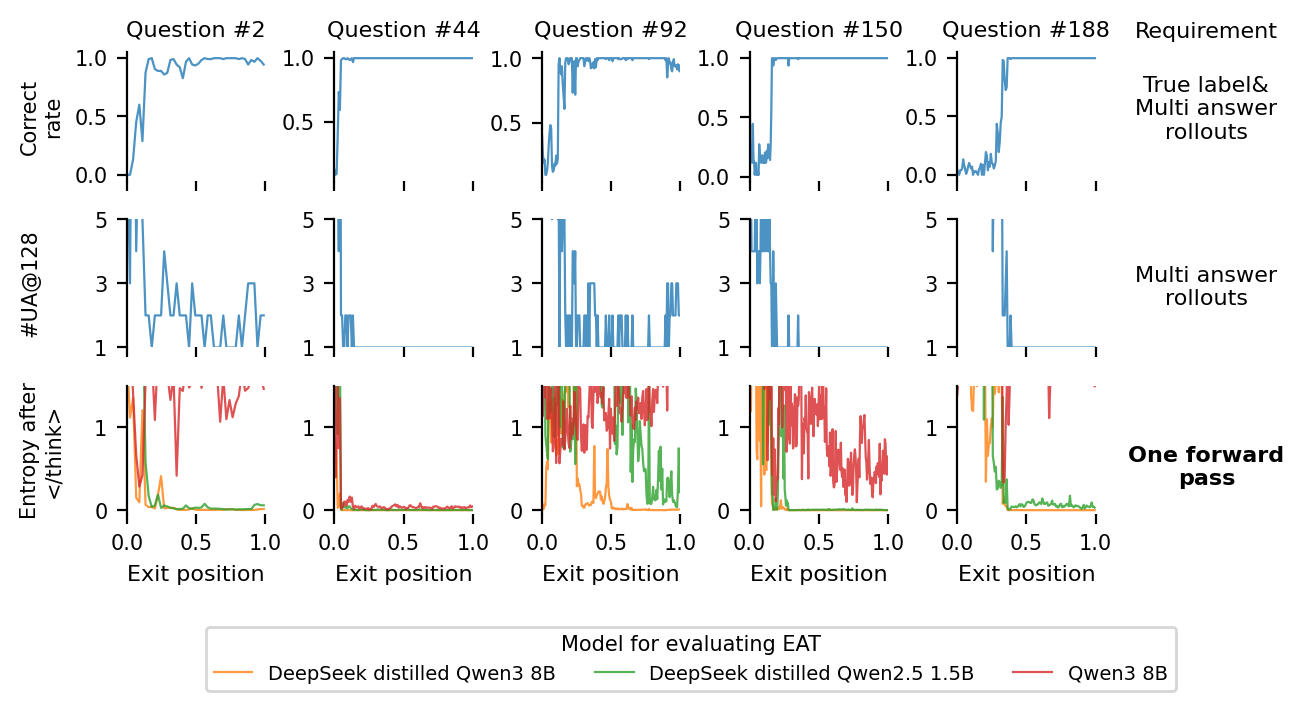

In [303]:
# DPSK, long with sample, figure 1

from matplotlib import cm
my_colors = cm.tab10([0,1,2,3])


QIDS = [
    2, 44, 92, 150, 188
]

fig, ax = plt.subplots(3, len(QIDS), figsize=(6.25, 3.0), sharex='col')
fig.subplots_adjust(wspace=0.5, hspace=0.3)
line_config = {
    'linewidth': 0.8,
    'alpha': 0.8,
}

acc_dir = '/root/tts_and_entropy/outputs/cached_results_dpsk_long_use_sample'
entropy_dir = '/root/tts_and_entropy/outputs/entropy_log_math'

for i, a in enumerate(ax[0]):
    a.set_title(f'Question #{QIDS[i]}', fontsize=8)

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.tick_params(labelsize=7.5, axis='both')

for a in ax[-1]:
    a.set_xlabel('Exit position', fontsize=8)
    a.set_xticks([0.0, 0.5, 1.0])
    a.set_xlim(0, 1.0)

for i, qid in enumerate(QIDS):
    acc, ent, ua, ans = load_log(
            qid,
            acc_dir,
            entropy_dir,
            'entropy_{}_new_dpsk_new_with_sample_ngram_with_final_answer_str.npy',
            include_ans=True
        )

    X = np.arange(len(acc)) / (len(acc) - 1)

    ax[0, i].plot(X[::2], acc[::2], **line_config)
    ENT = ent[:, 1][::2]
    ax[2, i].plot(X[:-1][::2], ENT, label='DeepSeek distilled Qwen3 8B',
                  c=my_colors[1],
                   **line_config)
    ax[1, i].plot(X[::2], ua[::2], **line_config)

    _, ent_alt = load_log(
            qid,
            acc_dir,
            entropy_dir,
            'entropy_{}_new_dpsk_new_with_sample_ngram_with_final_answer_str_eatEvaluedBydpsk_small.npy',
            include_ans=False
        )
    ENT = ent_alt[:, 1][::2]
    ax[2, i].plot(X[:-1][::2], ENT, label='DeepSeek distilled Qwen2.5 1.5B',
                  c=my_colors[2],
                   **line_config)

    _, ent_alt = load_log(
            qid,
            acc_dir,
            entropy_dir,
            'entropy_{}_new_dpsk_new_with_sample_ngram_with_final_answer_str_eatEvaluedByqwen_base.npy',
            include_ans=False
        )
    ENT = ent_alt[:, 1][::2]
    ax[2, i].plot(X[:-1][::2], ENT, label='Qwen3 8B',
                  c=my_colors[3],
                   **line_config)

    if i == 0:
        ax[0, 0].set_ylabel('Correct\nrate', fontsize=7.5)
        ax[2, 0].set_ylabel('Entropy after\n</think>', fontsize=7.5)
        # ax[1, 0].set_ylabel('#Unique\nanswers', fontsize=7.5)
        ax[1, 0].set_ylabel('#UA@128\n', fontsize=7.5)

ax[2, 0].set_ylim(-0.05, 1.5)
ax[2, 1].set_ylim(-0.05, 1.5)
ax[2, 2].set_ylim(-0.05, 1.5)
ax[2, 3].set_ylim(-0.05, 1.5)
ax[2, 4].set_ylim(-0.05, 1.5)
fig.align_ylabels(ax[:, 0])

for a in ax[1]:
    a.set_ylim(1, 5)
    a.set_yticks([1, 3, 5])

ax[0, -1].text(
    1.8, 1.08, 'Requirement',
    transform=ax[0, -1].transAxes,
    ha='center', va='bottom', fontsize=8
)

ax[0, -1].text(
    1.8, 0.3, 'True label&\nMulti answer\nrollouts',
    transform=ax[0, -1].transAxes,
    ha='center', va='bottom', fontsize=8
)


ax[1, -1].text(
    1.8, 0.3, 
    'Multi answer\nrollouts',
    # 'Multi answer\nrollouts',
    transform=ax[1, -1].transAxes,
    ha='center', va='bottom', fontsize=8
)

ax[2, -1].text(
    1.8, 0.2, 'One forward\npass',
    transform=ax[2, -1].transAxes,
    ha='center', va='bottom', fontsize=8,
    fontweight='bold'
)

ax[2, 0].legend(
    title='Model for evaluating EAT',
    loc='upper left',
    fontsize=7.0,
    title_fontsize=7.5,
    bbox_to_anchor=(0.5, -0.8),
    ncol=3,
)

# fig.savefig(
#     '/root/figures/math_dpsk_long_with_sample_big_three_rows.pdf',
#     bbox_inches='tight',
# )


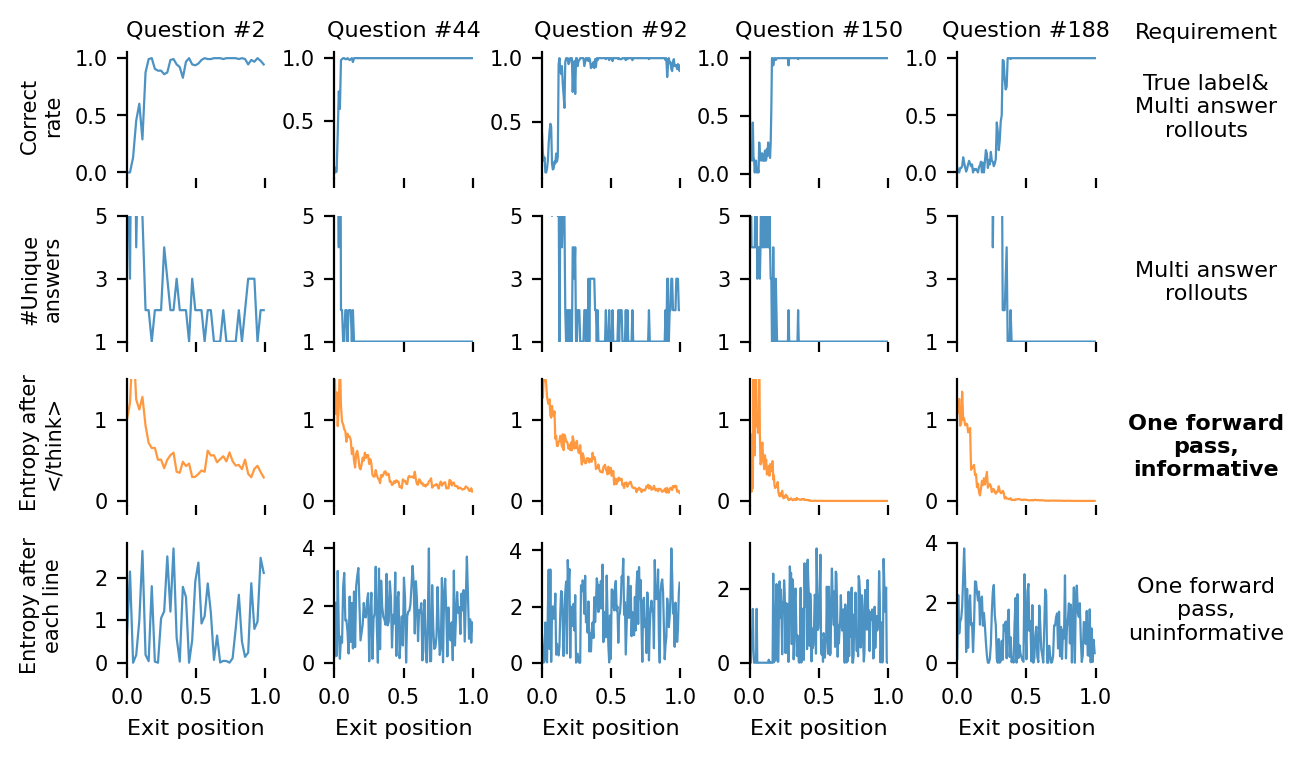

In [420]:
# DPSK, long with sample, figure 1

from matplotlib import cm
my_colors = cm.tab10([0,1,2,3])


QIDS = [
    2, 44, 92, 150, 188
]

fig, ax = plt.subplots(4, len(QIDS), figsize=(6.25, 4.0), sharex='col')
fig.subplots_adjust(wspace=0.5, hspace=0.3)
line_config = {
    'linewidth': 0.8,
    'alpha': 0.8,
}

acc_dir = '/root/tts_and_entropy/outputs/cached_results_dpsk_long_use_sample'
entropy_dir = '/root/tts_and_entropy/outputs/entropy_log_math'

for i, a in enumerate(ax[0]):
    a.set_title(f'Question #{QIDS[i]}', fontsize=8)

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.tick_params(labelsize=7.5, axis='both')

for a in ax[-1]:
    a.set_xlabel('Exit position', fontsize=8)
    a.set_xticks([0.0, 0.5, 1.0])
    a.set_xlim(0, 1.0)

for i, qid in enumerate(QIDS):
    acc, ent, ua, ans = load_log(
            qid,
            acc_dir,
            entropy_dir,
            'entropy_{}_new_dpsk_new_with_sample_ngram.npy',
            include_ans=True
        )

    X = np.arange(len(acc)) / (len(acc) - 1)

    ax[0, i].plot(X[::2], acc[::2], **line_config)
    ENT = ent[:, 1][::2]
    ax[2, i].plot(X[:-1][::2], ENT, label='unigram',
                  c=my_colors[1],
                   **line_config)

    ENT = ent[:, 0][::2]
    ax[3, i].plot(X[:-1][::2], ENT, label='unigram',
                  c=my_colors[0],
                   **line_config)
    
    ax[1, i].plot(X[::2], ua[::2], **line_config)


    if i == 0:
        ax[0, 0].set_ylabel('Correct\nrate', fontsize=7.5)
        ax[2, 0].set_ylabel('Entropy after\n</think>', fontsize=7.5)
        ax[3, 0].set_ylabel('Entropy after\neach line', fontsize=7.5)
        ax[1, 0].set_ylabel('#Unique\nanswers', fontsize=7.5)

ax[2, 0].set_ylim(-0.05, 1.5)
ax[2, 1].set_ylim(-0.05, 1.5)
ax[2, 2].set_ylim(-0.05, 1.5)
ax[2, 3].set_ylim(-0.05, 1.5)
ax[2, 4].set_ylim(-0.05, 1.5)
fig.align_ylabels(ax[:, 0])

for a in ax[1]:
    a.set_ylim(1, 5)
    a.set_yticks([1, 3, 5])

ax[0, -1].text(
    1.8, 1.08, 'Requirement',
    transform=ax[0, -1].transAxes,
    ha='center', va='bottom', fontsize=8
)

ax[0, -1].text(
    1.8, 0.3, 'True label&\nMulti answer\nrollouts',
    transform=ax[0, -1].transAxes,
    ha='center', va='bottom', fontsize=8
)


ax[1, -1].text(
    1.8, 0.3, 'Multi answer\nrollouts',
    transform=ax[1, -1].transAxes,
    ha='center', va='bottom', fontsize=8
)

ax[2, -1].text(
    1.8, 0.2, 'One forward\npass,\ninformative',
    transform=ax[2, -1].transAxes,
    ha='center', va='bottom', fontsize=8,
    fontweight='bold'
)

ax[3, -1].text(
    1.8, 0.2, 'One forward\npass,\nuninformative',
    transform=ax[3, -1].transAxes,
    ha='center', va='bottom', fontsize=8,
)

fig.savefig(
    '/root/figures/math_dpsk_long_with_sample_big_four_rows.pdf',
    bbox_inches='tight',
)


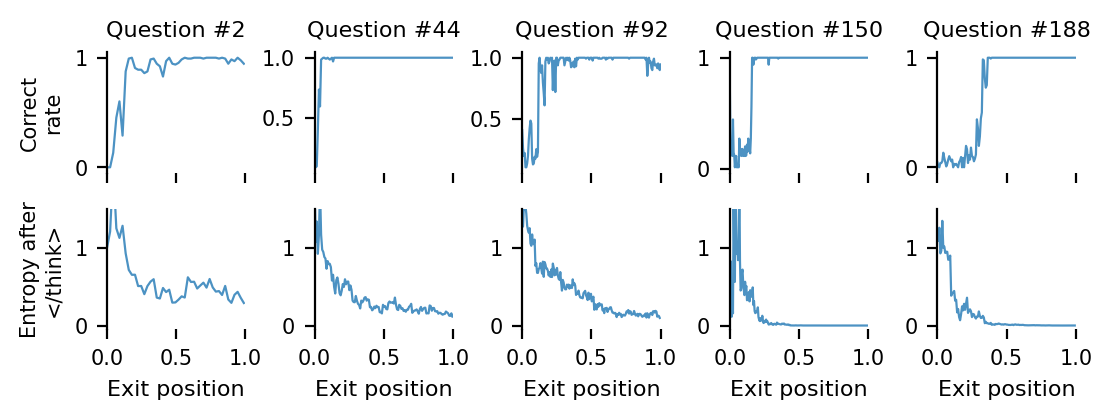

In [407]:
# DPSK, long with sample, figure 1

from matplotlib import cm
my_colors = cm.tab10([0,1,2,3])


QIDS = [
    2, 44, 92, 150, 188
]

fig, ax = plt.subplots(2, len(QIDS), figsize=(6.25, 1.8), sharex='col')
fig.subplots_adjust(wspace=0.5, hspace=0.3)
line_config = {
    'linewidth': 0.8,
    'alpha': 0.8,
}

acc_dir = '/root/tts_and_entropy/outputs/cached_results_dpsk_long_use_sample'
entropy_dir = '/root/tts_and_entropy/outputs/entropy_log_math'

for i, a in enumerate(ax[0]):
    a.set_title(f'Question #{QIDS[i]}', fontsize=8)

for a in ax.flatten():
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    a.tick_params(labelsize=7.5, axis='both')

for a in ax[-1]:
    a.set_xlabel('Exit position', fontsize=8)
    a.set_xticks([0.0, 0.5, 1.0])
    a.set_xlim(0, 1.0)

for i, qid in enumerate(QIDS):
    acc, ent, ua, ans = load_log(
            qid,
            acc_dir,
            entropy_dir,
            'entropy_{}_new_dpsk_new_with_sample_ngram.npy',
            include_ans=True
        )

    X = np.arange(len(acc)) / (len(acc) - 1)

    ax[0, i].plot(X[::2], acc[::2], **line_config)
    ENT = ent[:, 1][::2]
    ax[1, i].plot(X[:-1][::2], ENT, 
                   **line_config)


    if i == 0:
        ax[0, 0].set_ylabel('Correct\nrate', fontsize=7.5)
        ax[1, 0].set_ylabel('Entropy after\n</think>', fontsize=7.5)

ax[1, 0].set_ylim(-0.05, 1.5)
ax[1, 1].set_ylim(-0.05, 1.5)
ax[1, 2].set_ylim(-0.05, 1.5)
ax[1, 3].set_ylim(-0.05, 1.5)
ax[1, 4].set_ylim(-0.05, 1.5)
fig.align_ylabels(ax[:, 0])

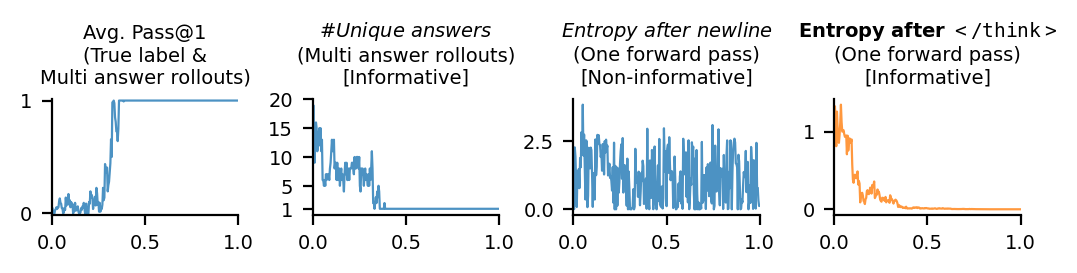

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(6.25, 0.8))

from matplotlib import cm
my_colors = cm.tab10([0,1,2,3])

line_config = {
        'linewidth': 0.8,
        'alpha': 0.8,
    }

fig.subplots_adjust(wspace=0.4)

qid = 188
acc_dir = '/root/tts_and_entropy/outputs/cached_results_dpsk_long_use_sample'
entropy_dir = '/root/tts_and_entropy/outputs/entropy_log_math'

acc, ent, ua, ans = load_log(
    qid,
    acc_dir,
    entropy_dir,
    'entropy_{}_new_dpsk_new_with_sample.npy',
    include_ans=True
)

X = np.arange(len(acc)) / (len(acc) - 1)
ax[0].plot(X, acc, **line_config)
# ax[1].plot(ent[:, -1], label='bigram',  **line_config)
ax[1].plot(X, ua, **line_config)
ax[3].plot(X, ent[:, 0], c=my_colors[1], label='unigram', **line_config)
ax[2].plot(X, ent[:, 1], label='unigram', **line_config)

ax[0].set_ylim(-0.01, 1.01)
ax[1].set_ylim(0.0, 20)
ax[1].set_yticks([1, 5, 10, 15, 20])
LF_SIZE = 7.0

ax[0].set_title(
    r'Avg. Pass@1' + '\n(True label &\nMulti answer rollouts)',
    fontsize=LF_SIZE
)
ax[1].set_title(
    '#' + r'${Unique~answers}$' + '\n(Multi answer rollouts)\n[Informative]',
    fontsize=LF_SIZE)
ax[3].set_title(
    r'${\bf{Entropy~after~ \tt{</think>} }}$' + '\n(One forward pass)\n[Informative]',
    fontsize=LF_SIZE)
ax[2].set_title(
    r'$Entropy~after~newline$' + '\n(One forward pass)\n[Non-informative]',
    fontsize=LF_SIZE)

for a in ax:
    # Hide frames
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    # a.set_xlabel('Line number', fontsize=LF_SIZE)
    a.tick_params(labelsize=LF_SIZE, axis='both')
    # a.set_xlim(0, 250)
    a.set_xlim(0, 1)
    a.set_box_aspect(0.618)

fig.savefig(
    '/root/figures/math_dpsk_long_with_sample_big_one_row.pdf',
    bbox_inches='tight',
)


In [36]:
result_dict = {}
gpqa_result = '/root/tts_and_entropy/outputs/gpqa_diamond_150.npz'
gpqa_data = np.load(gpqa_result)
result_dict['gpqa'] = {
    'acc': gpqa_data['acc'],
    'entropy': gpqa_data['entropy'],
    'eat': gpqa_data['eat'],
    'ua': gpqa_data['unique_answers'],
}

In [98]:
all_configs = [
    ('MATH500', 188, '/root/tts_and_entropy/outputs/cached_results_dpsk_long_use_sample', 'entropy_{}_new_dpsk_new_with_sample.npy'),
    ('AIME2025-I', 2, '/root/tts_and_entropy/outputs/cached_results_dpsk_aime2025_long_long', 'entropy_{}_new_dpsk_new_with_sample_ngram_long_aime2025.npy'),
    ('GPQA-Diamond (Multi-choice)', 51, '/root/tts_and_entropy/outputs/cached_resultsgpqa_mc_dpsk_new', 'entropy_{}_new_dpsk_new_with_sample_ngram_gpqa_mc.npy'),
]

for dataset_name, qid, acc_dir, entropy_pattern in all_configs:
    acc, ent, ua, ans = load_log(
        qid,
        acc_dir,
        entropy_dir,
        entropy_pattern,
        include_ans=True
    )
    if 'MATH' in dataset_name:
        result_dict[dataset_name] = {
        'acc': acc,
        'entropy': ent[:, 1],
        'eat': ent[:, 0],
        'ua': ua
    }
    else:
        result_dict[dataset_name] = {
            'acc': acc,
            'entropy': ent[:, 0],
            'eat': ent[:, 1],
            'ua': ua
        }

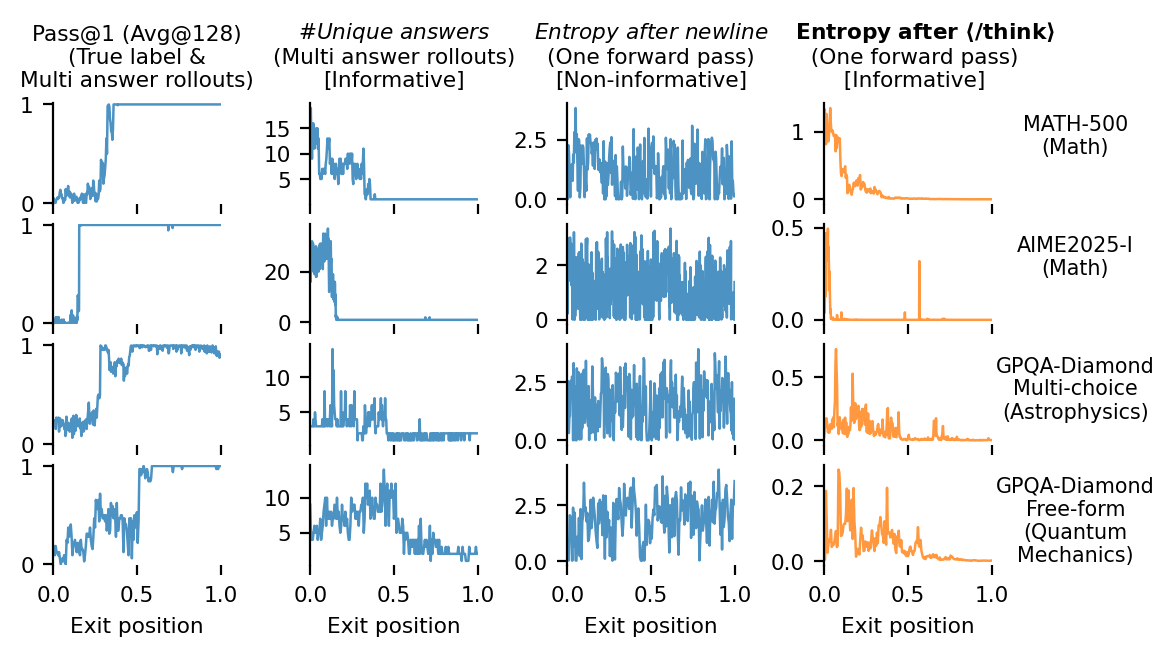

In [145]:
fig, ax = plt.subplots(4, 4, figsize=(6.25, 3.0), sharex='col')
from matplotlib import cm
my_colors = cm.tab10([0,1,2,3])

line_config = {
        'linewidth': 0.9,
        'alpha': 0.8,
    }

fig.subplots_adjust(wspace=0.3)

for i, key in enumerate(['MATH500', 'AIME2025-I', 'GPQA-Diamond (Multi-choice)', 'gpqa']):
    value = result_dict[key]
    acc = value['acc']
    ent = value['entropy']
    ua = value['ua']
    eat = value['eat']
    X = np.arange(len(acc)) / (len(acc) - 1)
    X2 = np.arange(len(ent)) / (len(ent) - 1)

    ax[i, 0].plot(X, acc, label=key, **line_config)
    ax[i, 1].plot(X, ua, **line_config)
    ax[i, 2].plot(X2, ent, label='unigram', **line_config)
    ax[i, 3].plot(X2, eat, c=my_colors[1], label='bigram', **line_config)

LF_SIZE = 7.8
ax[0, 0].set_title(
    r'Pass@1 (Avg@128)' + '\n(True label &\nMulti answer rollouts)',
    fontsize=LF_SIZE
)
ax[0, 1].set_title(
    '#' + r'${Unique~answers}$' + '\n(Multi answer rollouts)\n[Informative]',
    fontsize=LF_SIZE)
ax[0, 3].set_title(
    r'     ${\bf{Entropy~after~ \langle /think \rangle }}$' + '\n  (One forward pass)\n  [Informative]',
    fontsize=LF_SIZE)
ax[0, 2].set_title(
    r'$Entropy~after~newline$' + '\n(One forward pass)\n[Non-informative]',
    fontsize=LF_SIZE)

for a in ax[:, 0]:
    a.set_ylim(-0.01, 1.01)

for a in ax.flatten():
    # Hide frames
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.spines['bottom'].set_visible(False)
    # a.set_xlabel('Line number', fontsize=LF_SIZE)
    a.tick_params(labelsize=LF_SIZE, axis='both')
    # a.set_xlim(0, 250)
    a.set_xlim(0, 1)
    a.set_box_aspect(0.6)

# ax[1, -1].set_ylim(-0.1, 0.1)
# Add text to each row
for i, key in enumerate(['MATH-500\n(Math)', 'AIME2025-I\n(Math)', 'GPQA-Diamond\nMulti-choice\n(Astrophysics)', 'GPQA-Diamond\nFree-form\n(Quantum\nMechanics)']):
    ax[i, -1].text(
        1.5, 0.89, key,
        transform=ax[i, -1].transAxes,
        ha='center', va='top', fontsize=LF_SIZE * 0.95,
        c='black'
    )

for a in ax[-1, :]:
    a.set_xlabel('Exit position', fontsize=LF_SIZE)

fig.savefig('/root/figures/fig1.pdf', bbox_inches='tight')


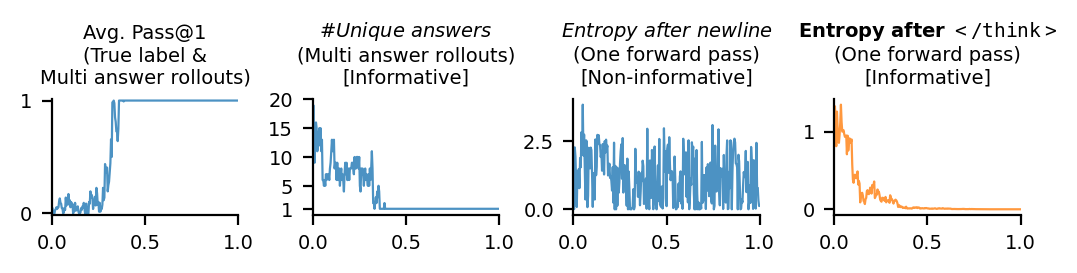

In [34]:
fig, ax = plt.subplots(1, 4, figsize=(6.25, 0.8))

from matplotlib import cm
my_colors = cm.tab10([0,1,2,3])

line_config = {
        'linewidth': 0.8,
        'alpha': 0.8,
    }

fig.subplots_adjust(wspace=0.4)

qid = 188
acc_dir = '/root/tts_and_entropy/outputs/cached_results_dpsk_long_use_sample'
entropy_dir = '/root/tts_and_entropy/outputs/entropy_log_math'

acc, ent, ua, ans = load_log(
    qid,
    acc_dir,
    entropy_dir,
    'entropy_{}_new_dpsk_new_with_sample.npy',
    include_ans=True
)

X = np.arange(len(acc)) / (len(acc) - 1)
ax[0].plot(X, acc, **line_config)
# ax[1].plot(ent[:, -1], label='bigram',  **line_config)
ax[1].plot(X, ua, **line_config)
ax[3].plot(X, ent[:, 0], c=my_colors[1], label='unigram', **line_config)
ax[2].plot(X, ent[:, 1], label='unigram', **line_config)

ax[0].set_ylim(-0.01, 1.01)
ax[1].set_ylim(0.0, 20)
ax[1].set_yticks([1, 5, 10, 15, 20])
LF_SIZE = 7.0

ax[0].set_title(
    r'Avg. Pass@1' + '\n(True label &\nMulti answer rollouts)',
    fontsize=LF_SIZE
)
ax[1].set_title(
    '#' + r'${Unique~answers}$' + '\n(Multi answer rollouts)\n[Informative]',
    fontsize=LF_SIZE)
ax[3].set_title(
    r'${\bf{Entropy~after~ \tt{</think>} }}$' + '\n(One forward pass)\n[Informative]',
    fontsize=LF_SIZE)
ax[2].set_title(
    r'$Entropy~after~newline$' + '\n(One forward pass)\n[Non-informative]',
    fontsize=LF_SIZE)

for a in ax:
    # Hide frames
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    # a.set_xlabel('Line number', fontsize=LF_SIZE)
    a.tick_params(labelsize=LF_SIZE, axis='both')
    # a.set_xlim(0, 250)
    a.set_xlim(0, 1)
    a.set_box_aspect(0.618)

fig.savefig(
    '/root/figures/math_dpsk_long_with_sample_big_one_row.pdf',
    bbox_inches='tight',
)


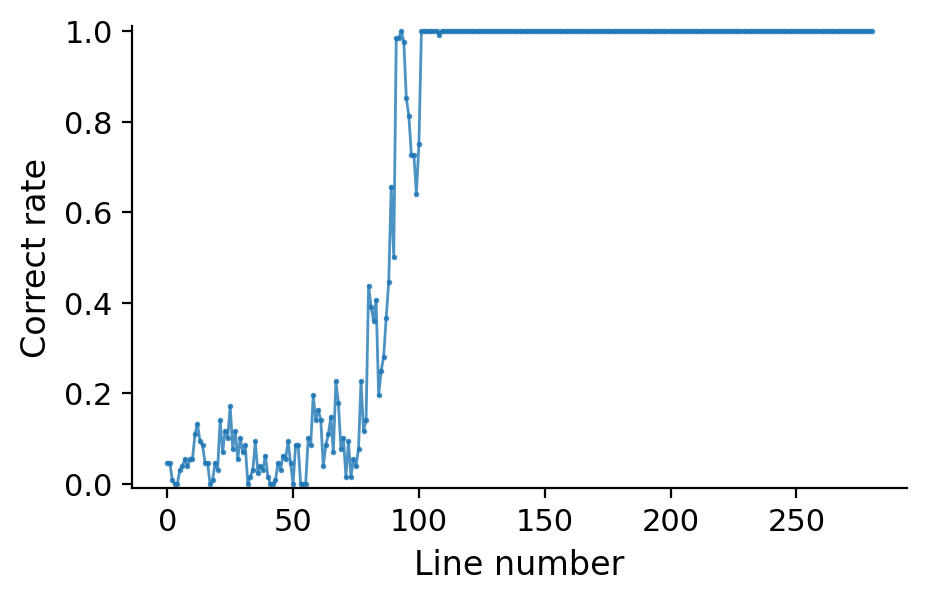

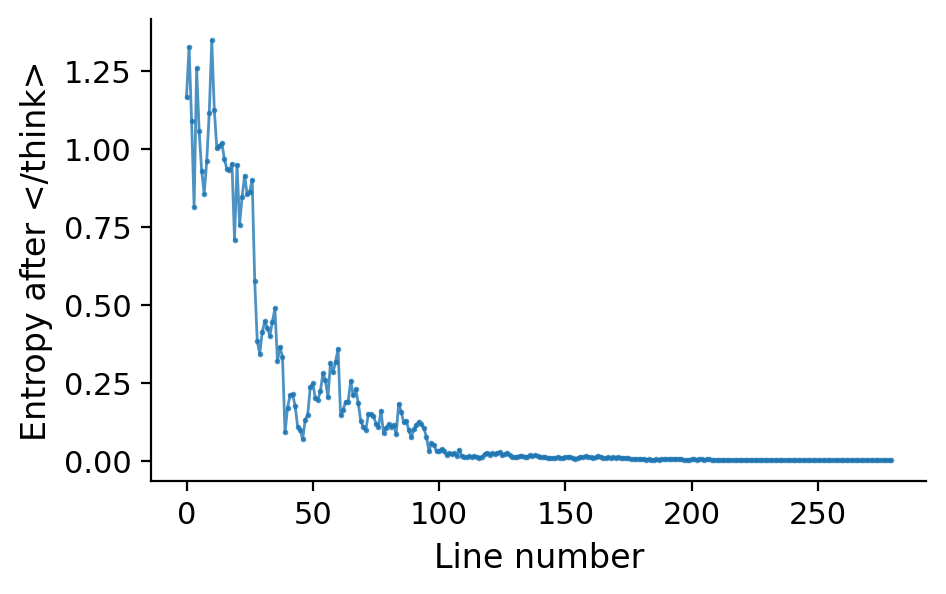

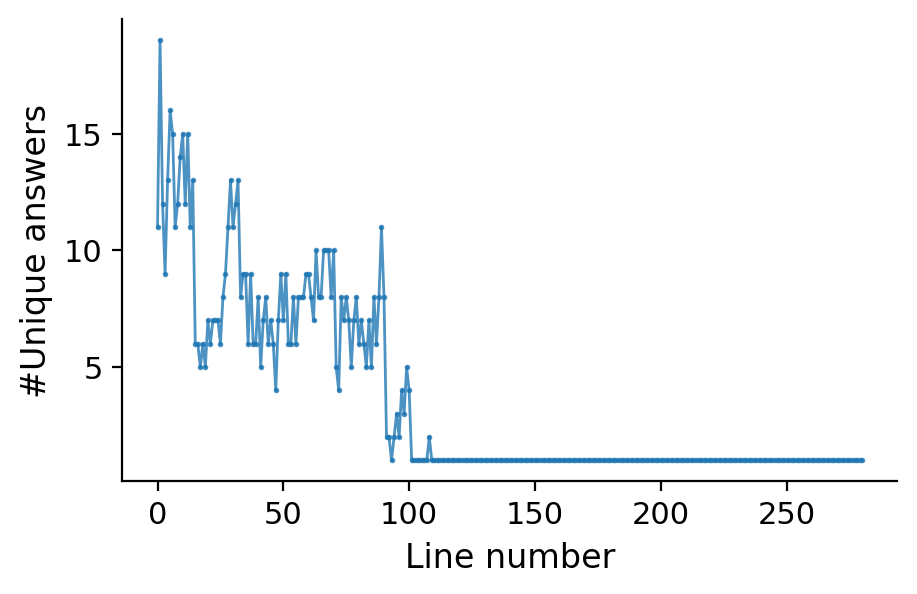

In [410]:
ax = []
for i in range(3):
    fig, _ax = plt.subplots(1, 1, figsize=(5, 3))
    ax.append(_ax)

line_config = {
        'linewidth': 1.0,
        'alpha': 0.8,
        'marker': 'o',
        'markersize': 1,
    }

QID = 188
# ax[0].set_title(f'Question ID: {QID}')

acc_dir = '/root/tts_and_entropy/outputs/cached_results_dpsk_long_use_sample'
entropy_dir = '/root/tts_and_entropy/outputs/entropy_log_math'

acc, ent, ua, ans = load_log(
    qid,
    acc_dir,
    entropy_dir,
    'entropy_{}_new_dpsk_new_with_sample_ngram.npy',
    include_ans=True
)


ax[0].plot(acc, **line_config)
ax[1].plot(ent[:, 1], label='unigram', **line_config)
# ax[1].plot(ent[:, -1], label='bigram',  **line_config)
ax[2].plot(ua, **line_config)

ax[0].set_ylim(-0.01, 1.01)
# ax[1].set_ylim(0.0, 4.0)
LF_SIZE = 12

ax[0].set_ylabel('Correct rate', fontsize=LF_SIZE)
ax[1].set_ylabel('Entropy after </think>', fontsize=LF_SIZE)
ax[2].set_ylabel('#Unique answers', fontsize=LF_SIZE)

# ax[1].legend()

for a in ax:
    # Hide frames
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlabel('Line number', fontsize=LF_SIZE)
    a.tick_params(labelsize=LF_SIZE - 1.0, axis='both')

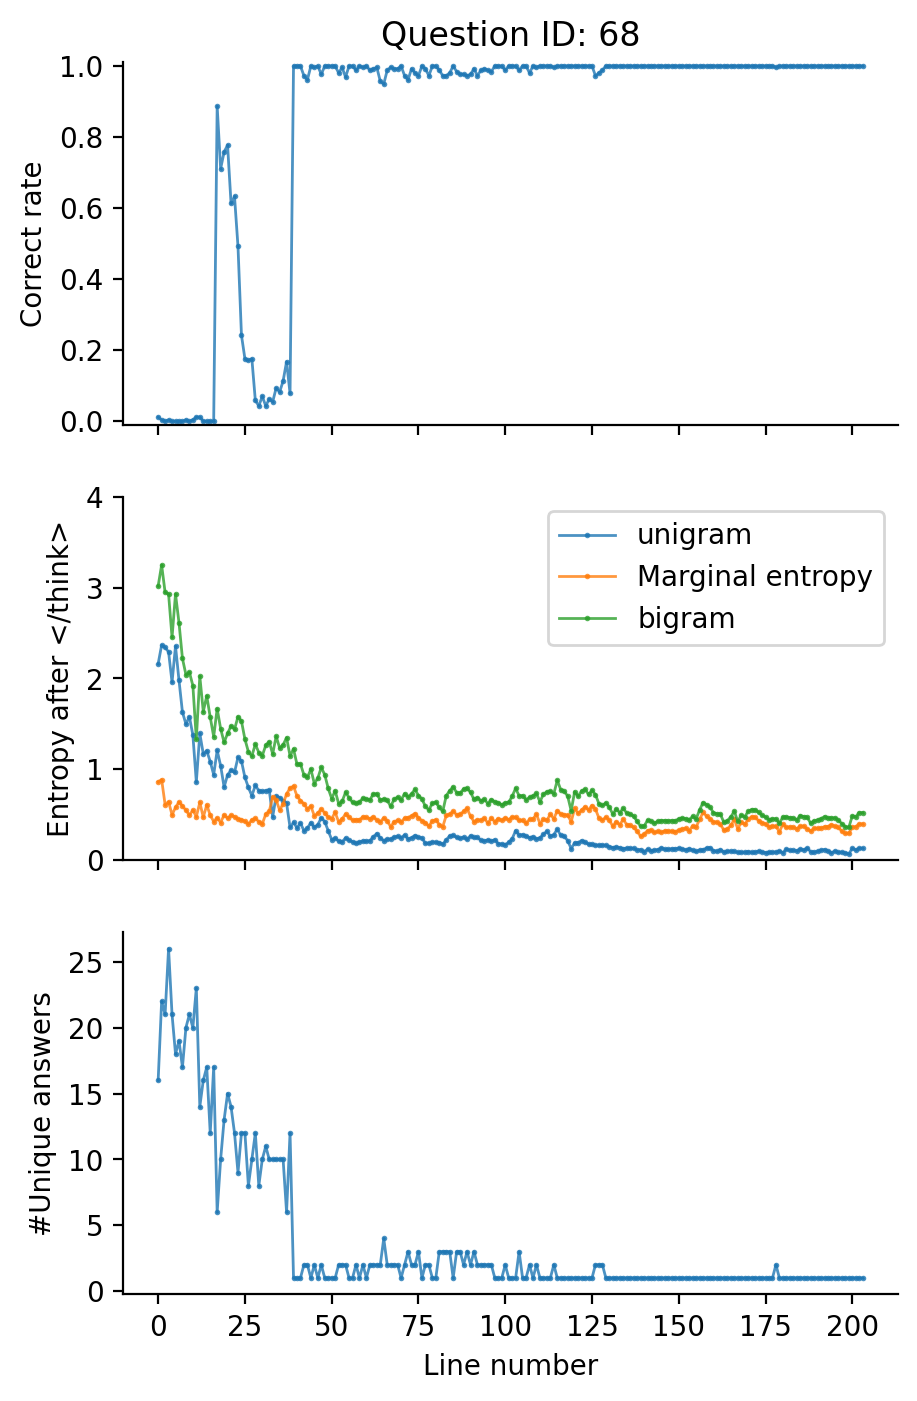

In [177]:
fig, ax = plt.subplots(3, figsize=(5, 8), sharex='col')

line_config = {
        'linewidth': 1.0,
        'alpha': 0.8,
        'marker': 'o',
        'markersize': 1,
    }

QID = 59
QID = 68

ax[0].set_title(f'Question ID: {QID}')

ans, ua, acc, ent, no_thinking_entropy = load_log(QID)

ax[0].plot(acc, **line_config)
# ax[1].plot(ent[:, 0], **line_config)
# ax[1].plot(ent[:, -1], **line_config)

ax[1].plot(ent[:, 0], label='unigram', **line_config)
ax[1].plot(ent[:, -1] - ent[:, 0], label='Marginal entropy' ,**line_config)
ax[1].plot(ent[:, -1], label='bigram', **line_config)
ax[1].legend()

# ax[1].axhline(no_thinking_entropy, color='red', linestyle='--', label='No Thinking Entropy')
ax[2].plot(ua, **line_config)

# ax[1].set_yscale('exp')

ax[0].set_ylim(-0.01, 1.01)
ax[1].set_ylim(0.0, 4.0)

ax[0].set_ylabel('Correct rate')
ax[1].set_ylabel('Entropy after </think>')
ax[2].set_ylabel('#Unique answers')

for a in ax:
    # Hide frames
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    # a.axvline(ent[:, 0].argmin(), color='gray', linestyle='--', label='Min Entropy', alpha=0.5)
ax[-1].set_xlabel('Line number')
    # a.spines['bottom'].set_visible(False)
    # a.tick_params(left=False, bottom=False)

R = model_solutions[QID]['response']
R = R.split('</think>')[0]
R = R.split("<think>")[1].split('\n')[1::2]

optimal_line_number = ent[:, 0].argmin()

# for i in range(optimal_line_number - 5, optimal_line_number + 5):
#     if i == optimal_line_number:
#         print(f"Line {i}: {R[i]} <--- Optimal")
#     else:
#         print(f"Line {i}: {R[i]}")

# ax[1].set_yscale('log')

Line 7: Each of these units is distinct because the people are distinct.
Line 8: The block is distinct from the other people, and the other people are distinct from each other.
Line 9: So, first, arrange these 6 units in a circle.
Line 10: Number of ways to arrange 6 distinct units in a circle is (6-1)! = 5!.
Line 11: Now, within the block, Pierre, Rosa, and Thomas can be arranged in 3! = 6 ways.
Line 12: So, total ways should be 5! × 6. <--- Optimal
Line 13: But is that correct? Let me think.
Line 14: When I treat them as a single block, I'm assuming that the block is a single position, but in a circle, the block itself has a direction or something? No, in circular arrangements, when we treat a group as a single entity, we still need to consider the internal arrangements.
Line 15: But in this case, since the block is three people sitting together, and the table is round, I need to make sure that the block is considered as a single unit but with the three people in a line within the bl

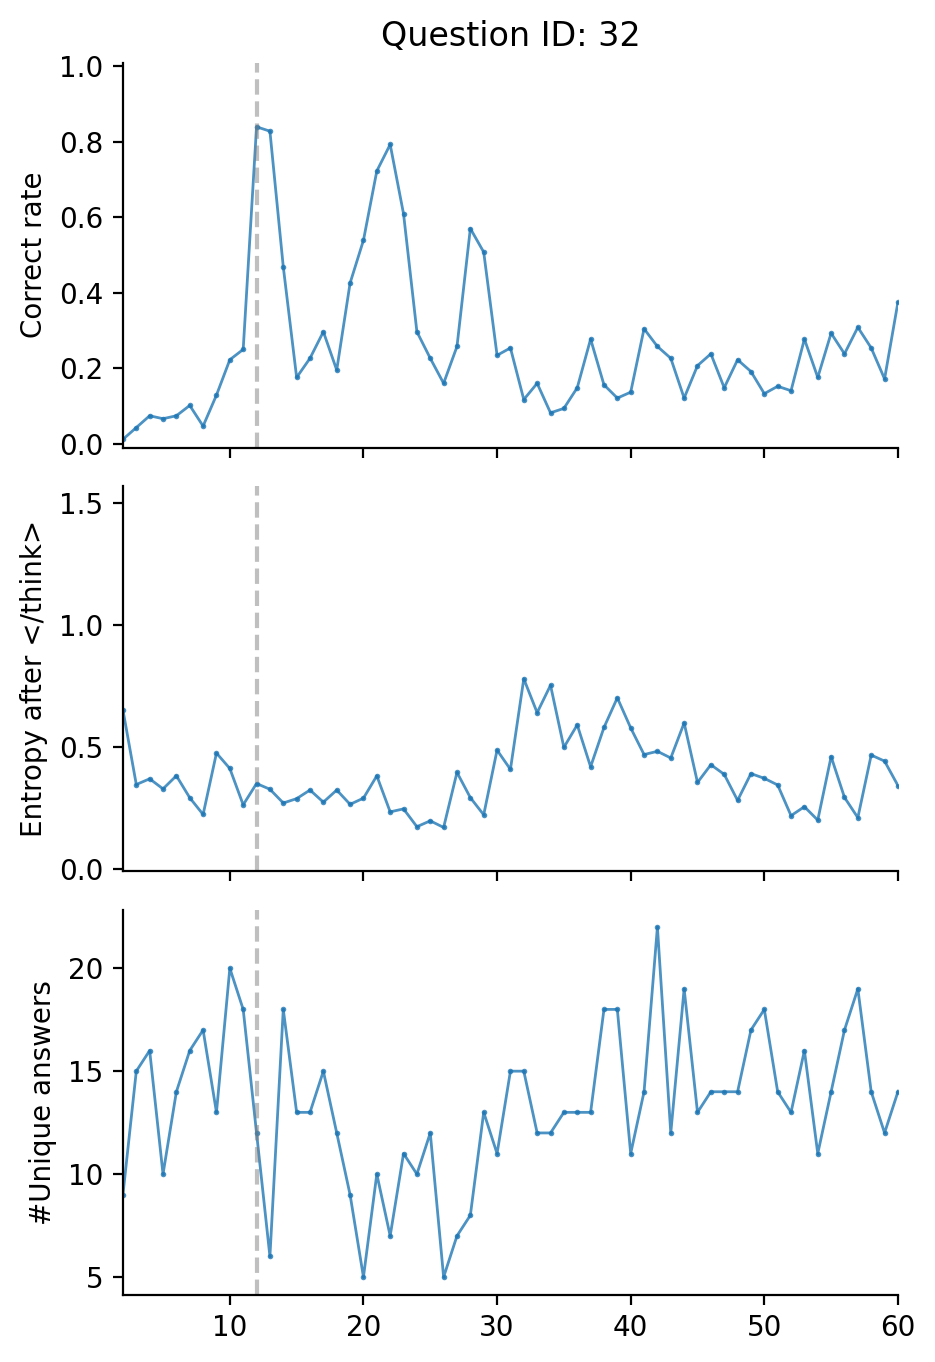

In [361]:
fig, ax = plt.subplots(3, figsize=(5, 8), sharex='col')

line_config = {
        'linewidth': 1.0,
        'alpha': 0.8,
        'marker': 'o',
        'markersize': 1,
    }

QID = 32
# QID = 12

fig.subplots_adjust(hspace=0.1)

ax[0].set_title(f'Question ID: {QID}')

ans, ua, acc, ent, no_thinking_entropy = load_log(QID)

ax[0].plot(acc, **line_config)
ax[1].plot(ent[:, 0], **line_config)
# ax[1].axhline(no_thinking_entropy, color='red', linestyle='--', label='No Thinking Entropy')
ax[2].plot(ua, **line_config)

# ax[1].set_yscale('exp')

ax[0].set_ylim(-0.01, 1.01)
# ax[1].set_ylim(10**-1, 2.0)

ax[0].set_ylabel('Correct rate')
ax[1].set_ylabel('Entropy after </think>')
ax[2].set_ylabel('#Unique answers')

RIGHT = 60
optimal_line_number = acc[:RIGHT].argsort()[-1]
optimal_line_number = acc[:30].argsort()[-1]

for a in ax:
    # Hide frames
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.axvline(optimal_line_number, color='gray', linestyle='--', label='Min Entropy', alpha=0.5)
    # a.spines['bottom'].set_visible(False)
    # a.tick_params(left=False, bottom=False)
    a.set_xlim(2, RIGHT)

R = model_solutions[QID]['response']
R = R.split('</think>')[0]
R = R.split("<think>")[1].split('\n')[1::2]
# optimal_line_number = 100

# ax[1].set_yscale('log')
for i in range(optimal_line_number - 5, optimal_line_number + 5):
    if i == optimal_line_number:
        print(f"Line {i}: {R[i]} <--- Optimal")
    else:
        print(f"Line {i}: {R[i]}")

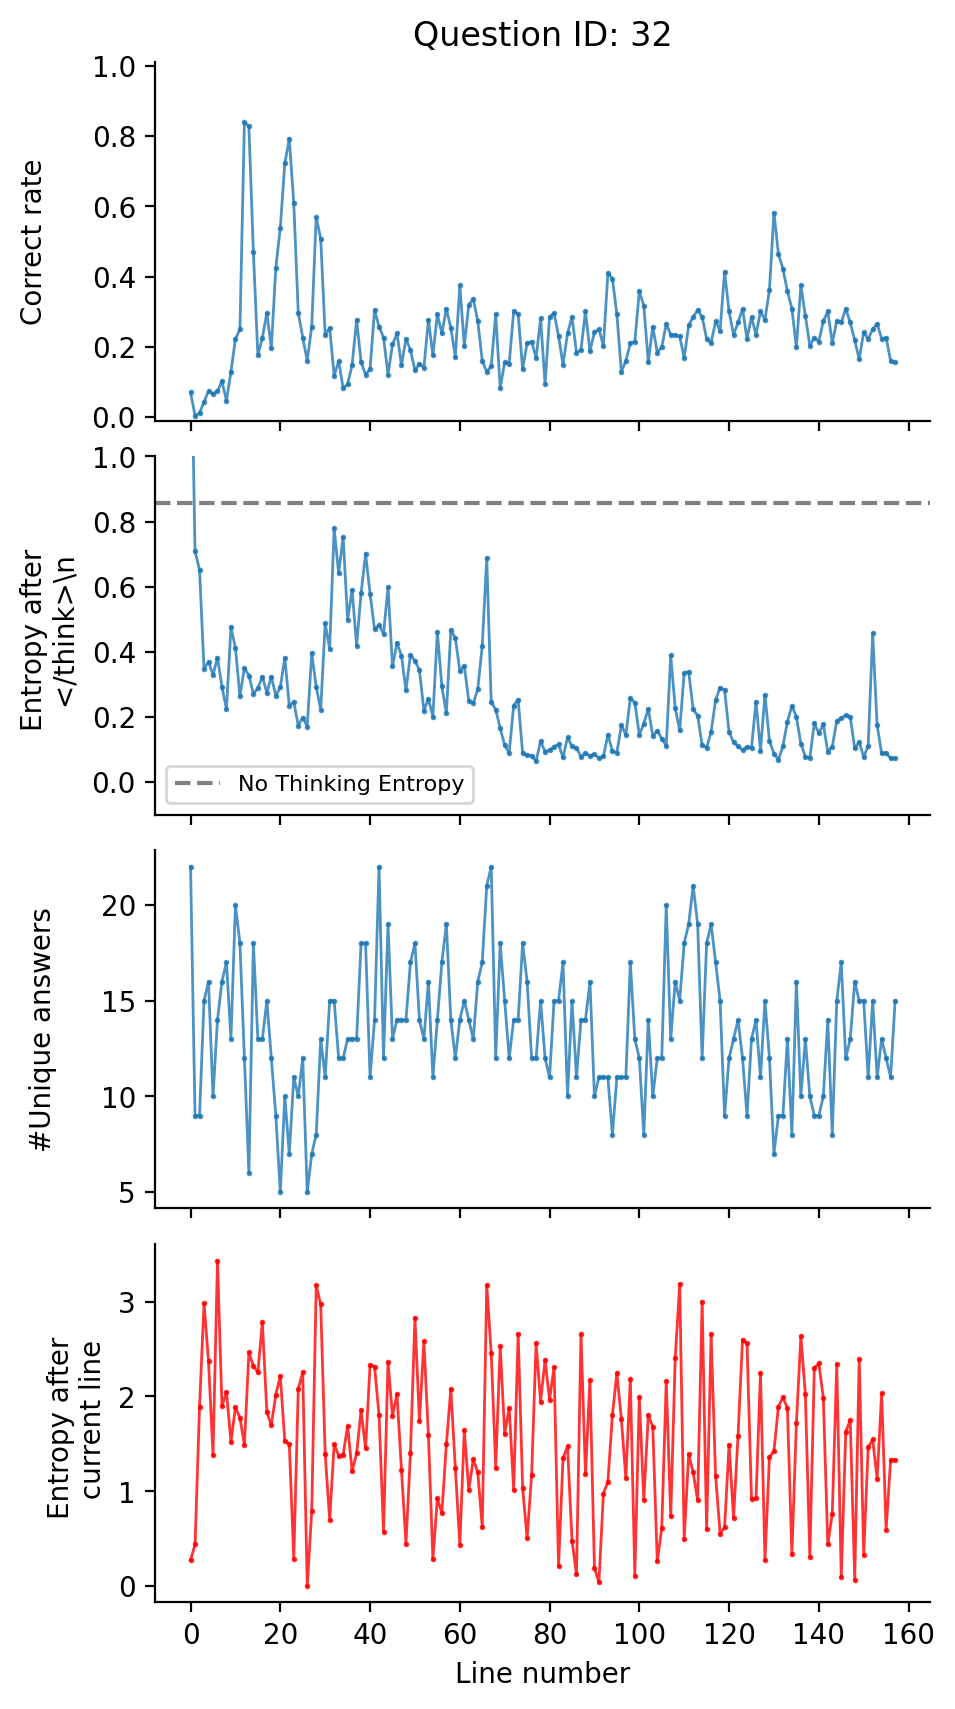

In [354]:
fig, ax = plt.subplots(4, figsize=(5, 10), sharex='col')

line_config = {
        'linewidth': 1.0,
        'alpha': 0.8,
        'marker': 'o',
        'markersize': 1,
    }

QID = 32
# QID = 15

fig.subplots_adjust(hspace=0.1)

ax[0].set_title(f'Question ID: {QID}')

ans, ua, acc, ent, no_thinking_entropy = load_log(QID)

ax[0].plot(acc, **line_config)
ax[1].plot(ent[:, 0], **line_config)
ax[1].axhline(no_thinking_entropy, color='gray', linestyle='--', label='No Thinking Entropy')
ax[2].plot(ua, **line_config)
ax[3].plot(ent[:, 1], c='red', **line_config)
ax[1].legend(fontsize=8)
# ax[1].set_yscale('exp')

ax[0].set_ylim(-0.01, 1.01)
# ax[1].set_ylim(10**-1, 2.0)

ax[0].set_ylabel('Correct rate\n', fontsize=10)
ax[1].set_ylabel('Entropy after \n </think>\\n', fontsize=10)
ax[2].set_ylabel('#Unique answers\n', fontsize=10)
ax[3].set_ylabel('Entropy after \n current line', fontsize=10)
ax[1].set_ylim(-0.1, 1.0)
ax[-1].set_xlabel('Line number', fontsize=10)

for a in ax:
    # Hide frames
    
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    # Adjust tick font size
    a.tick_params(axis='both', which='major', labelsize=10)

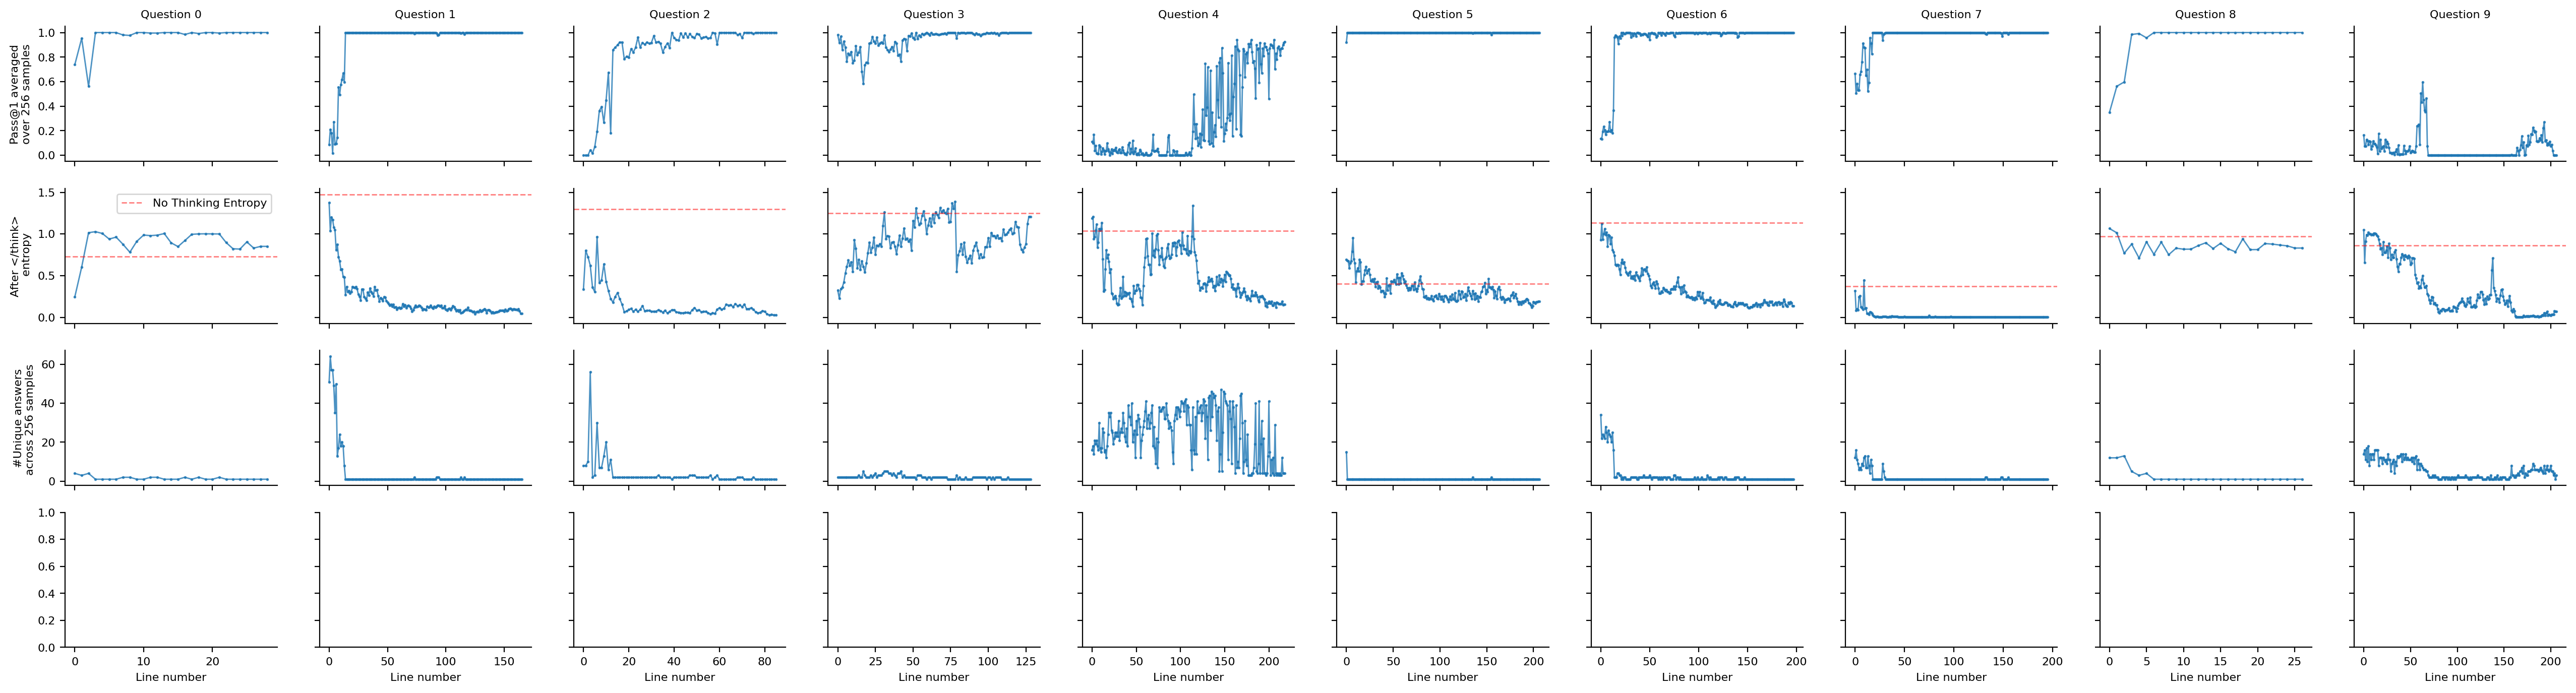

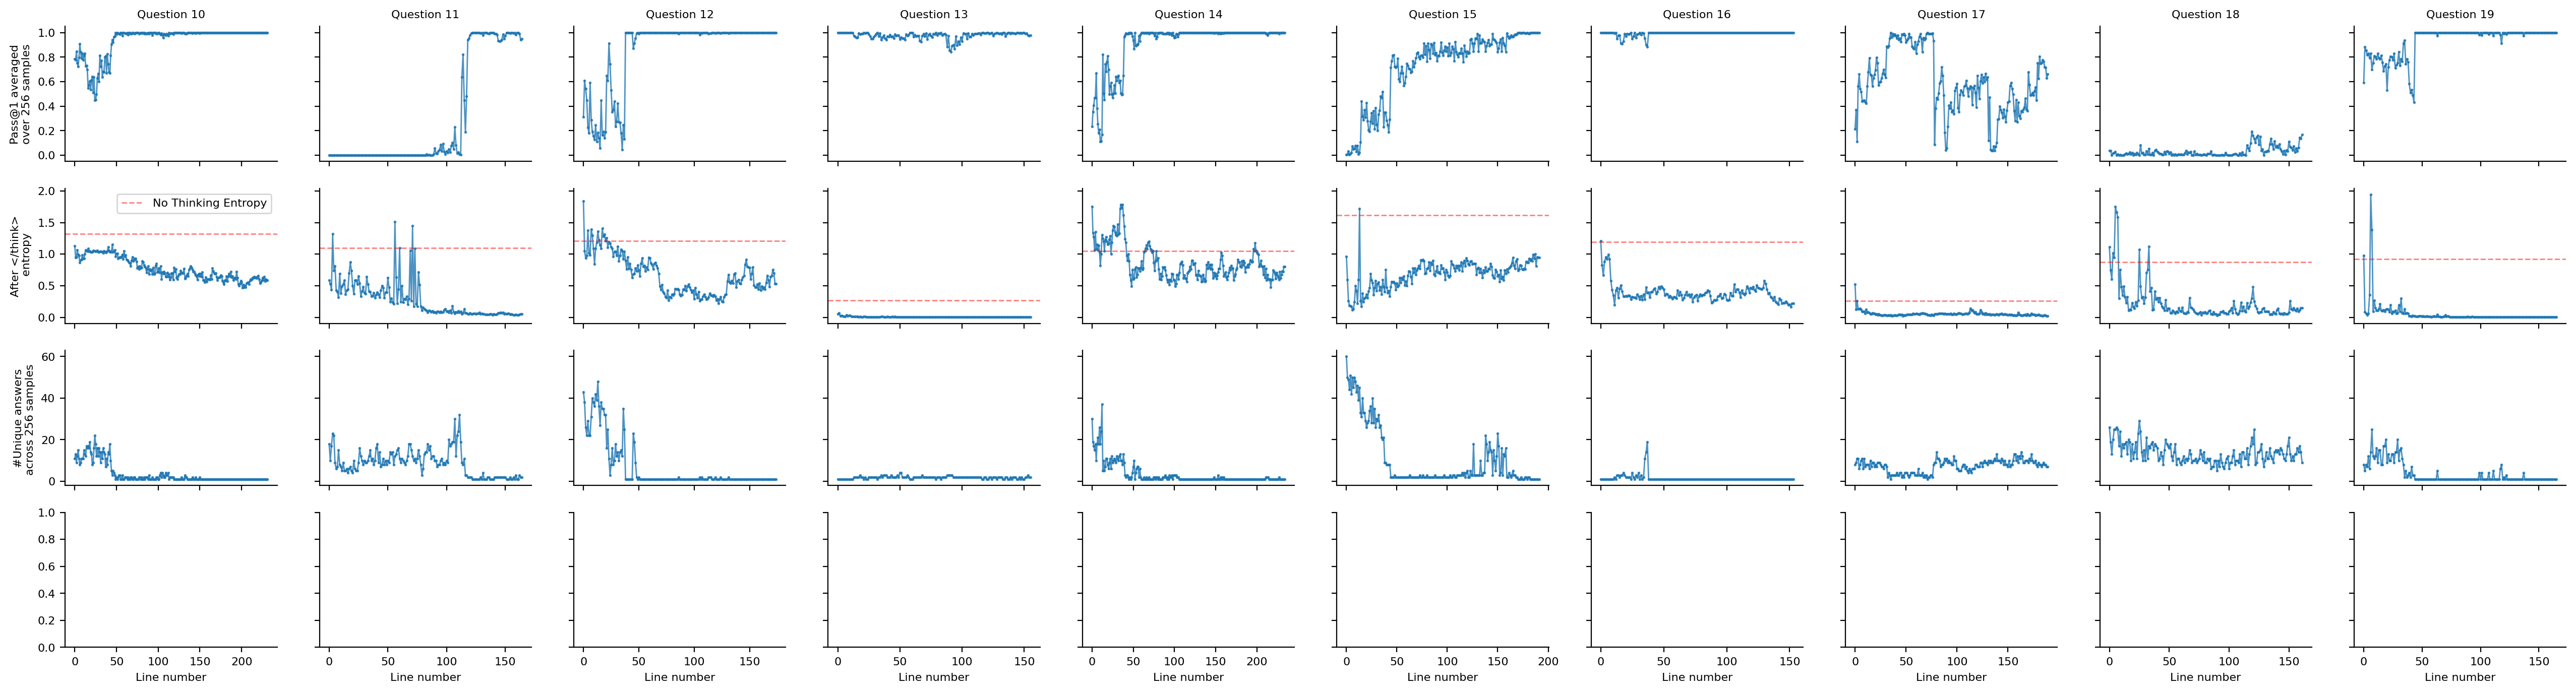

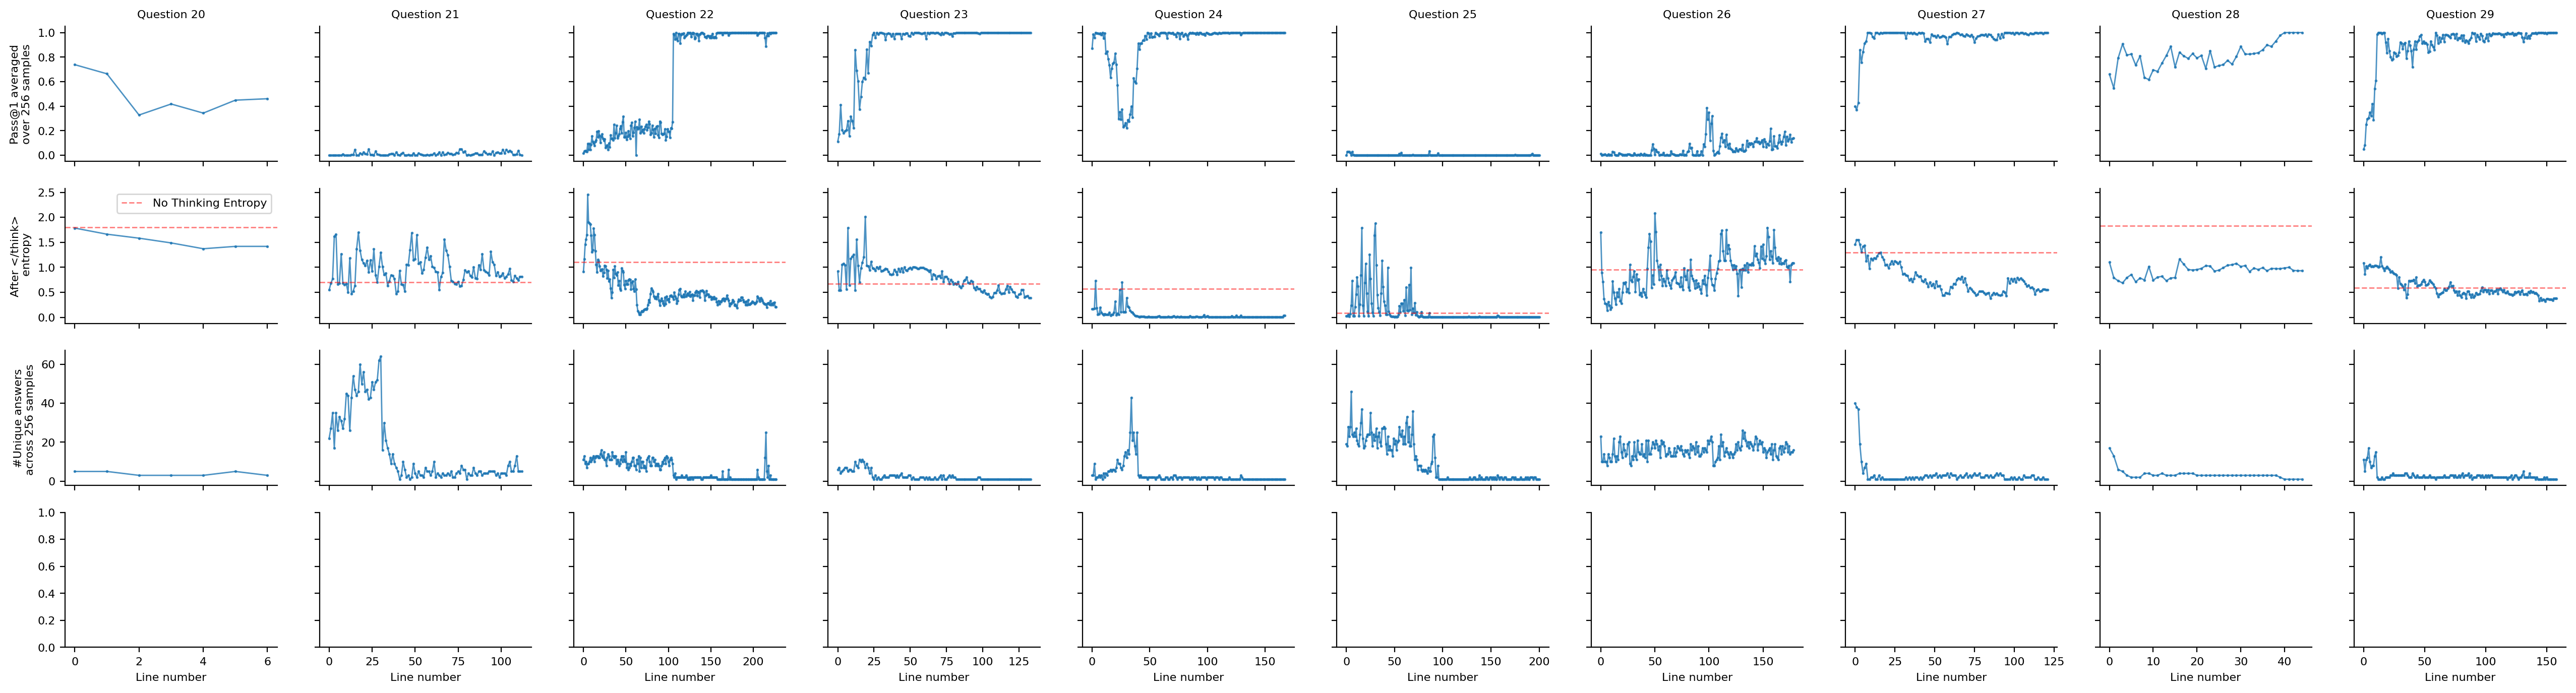

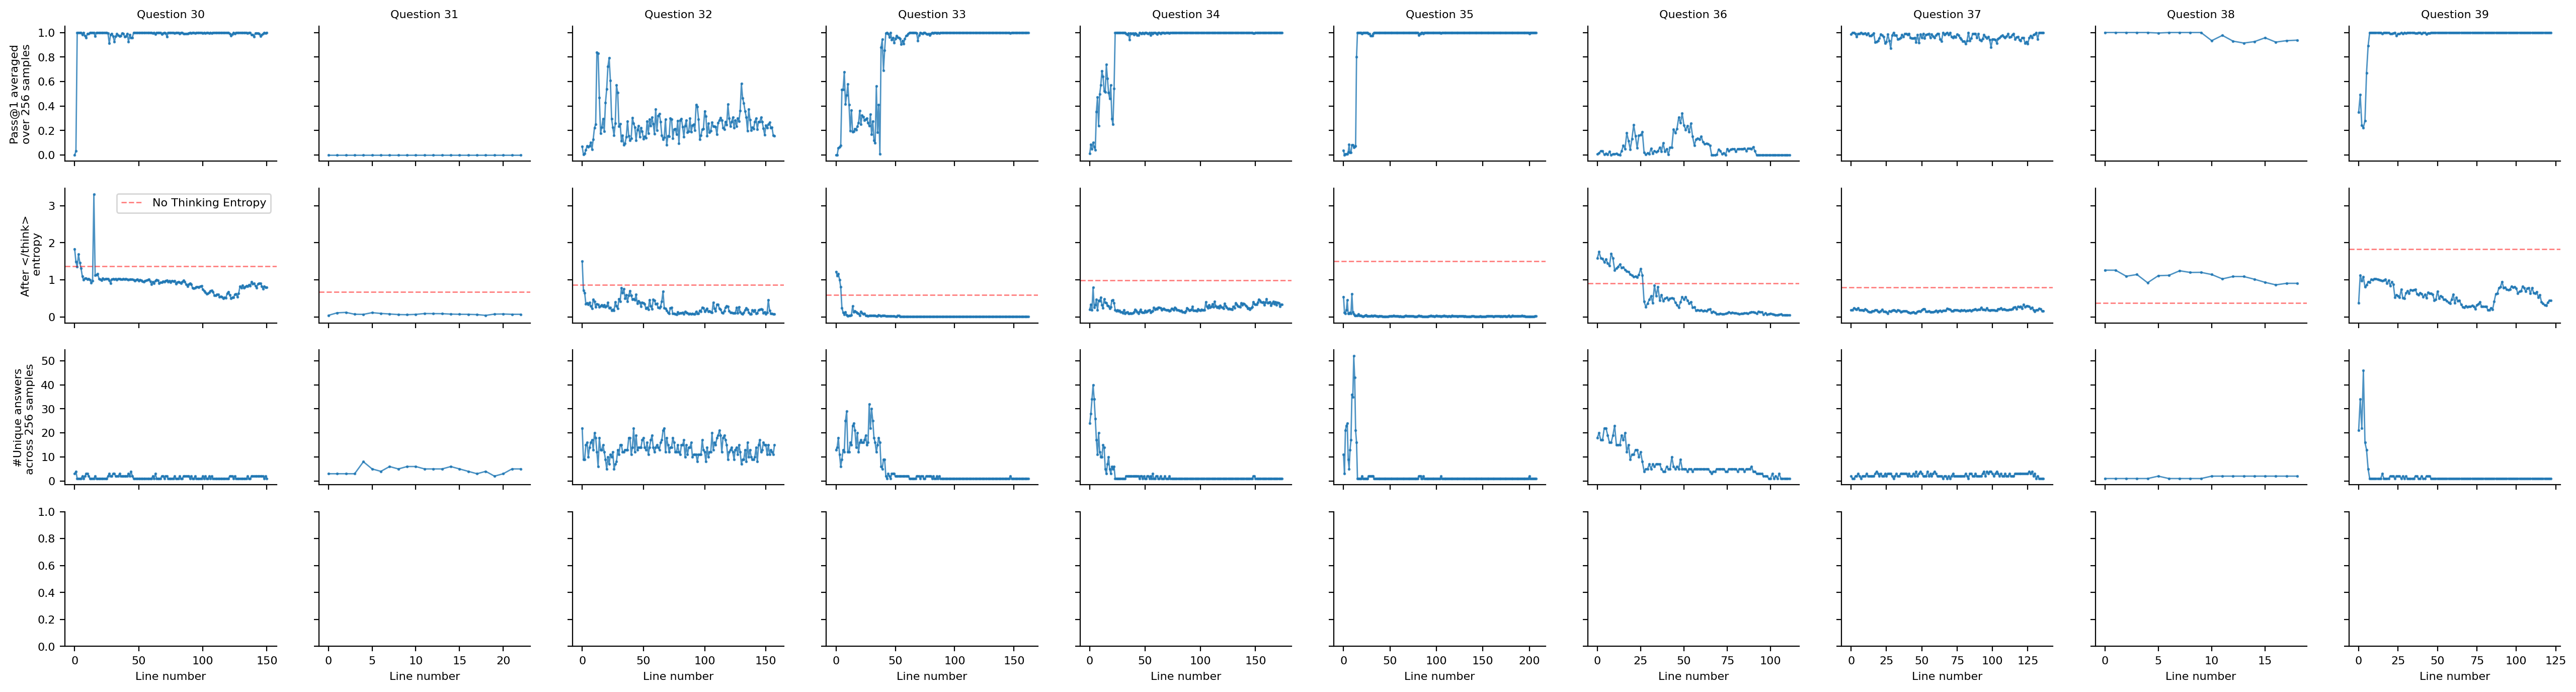

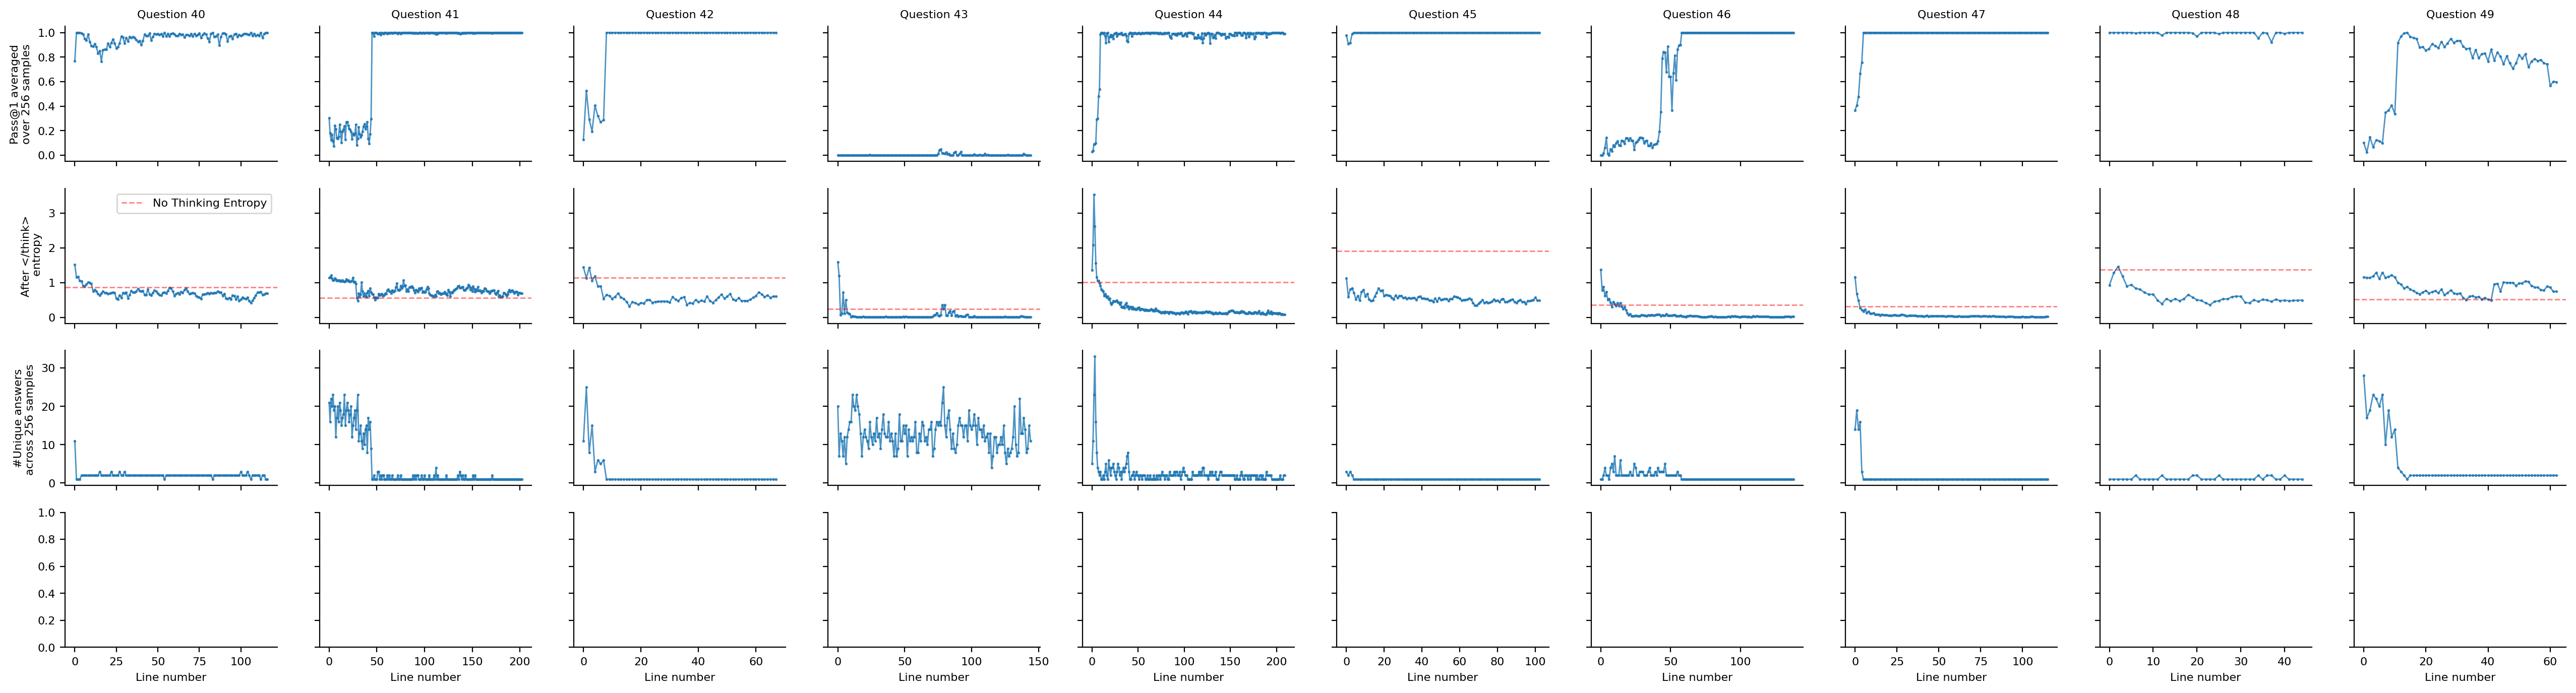

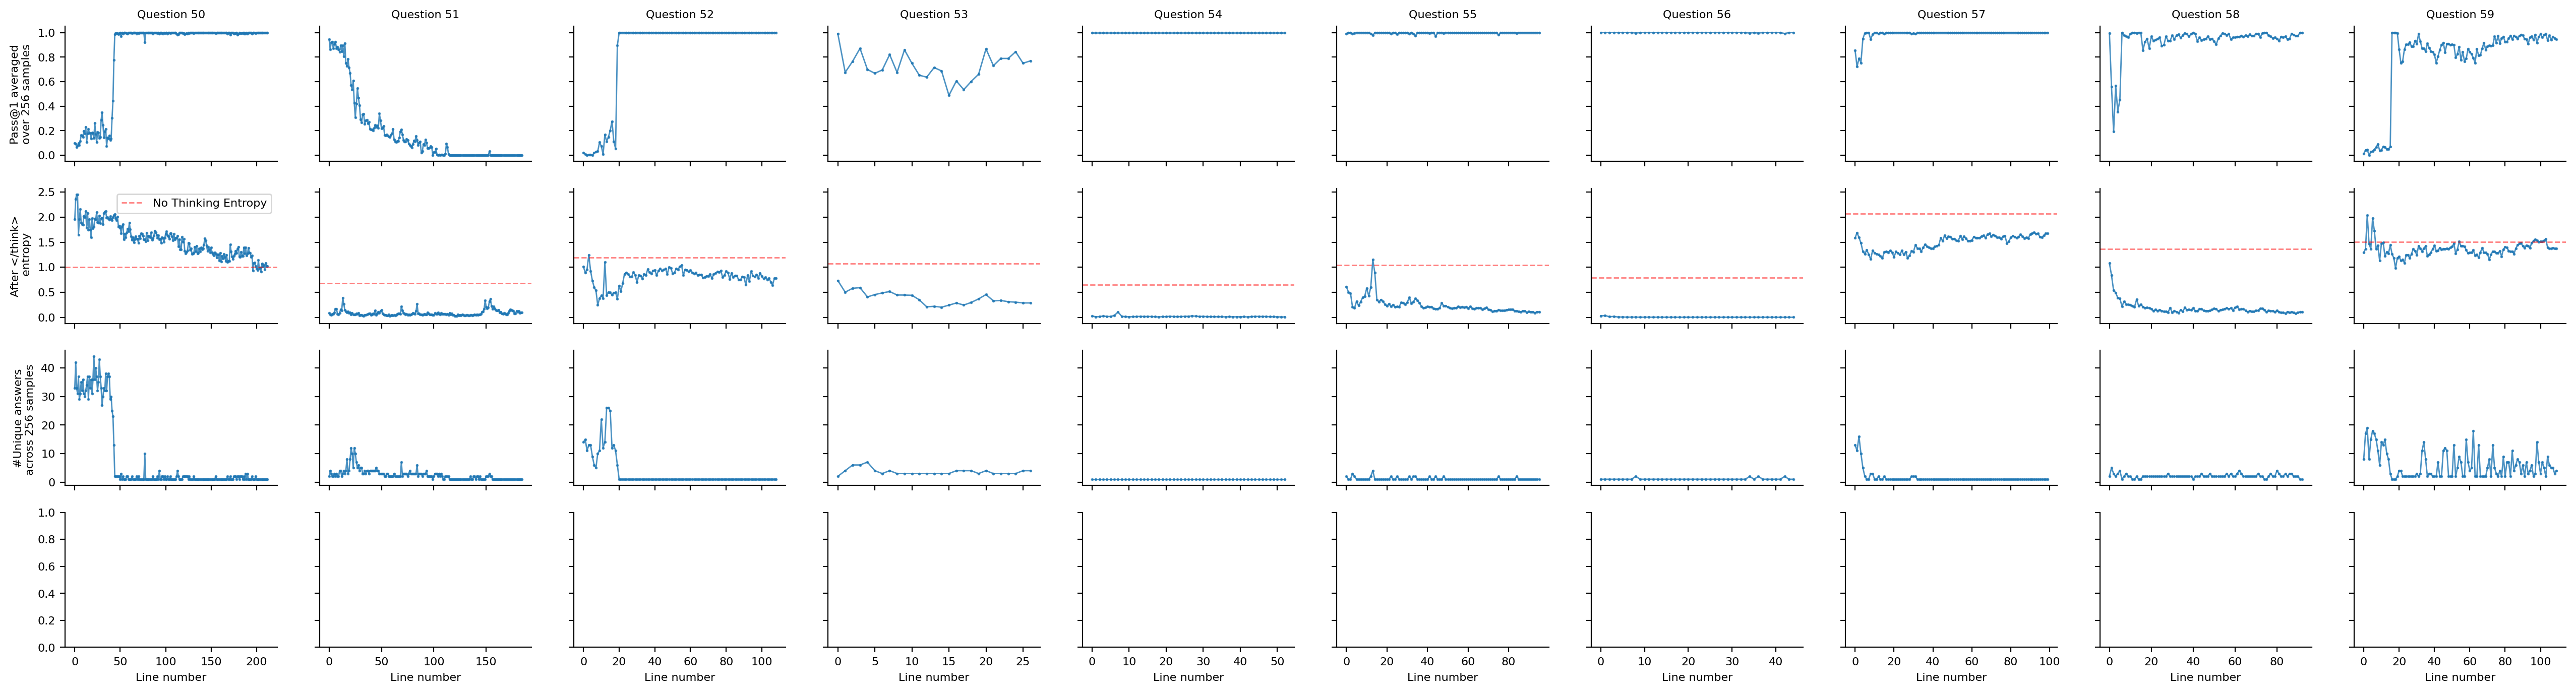

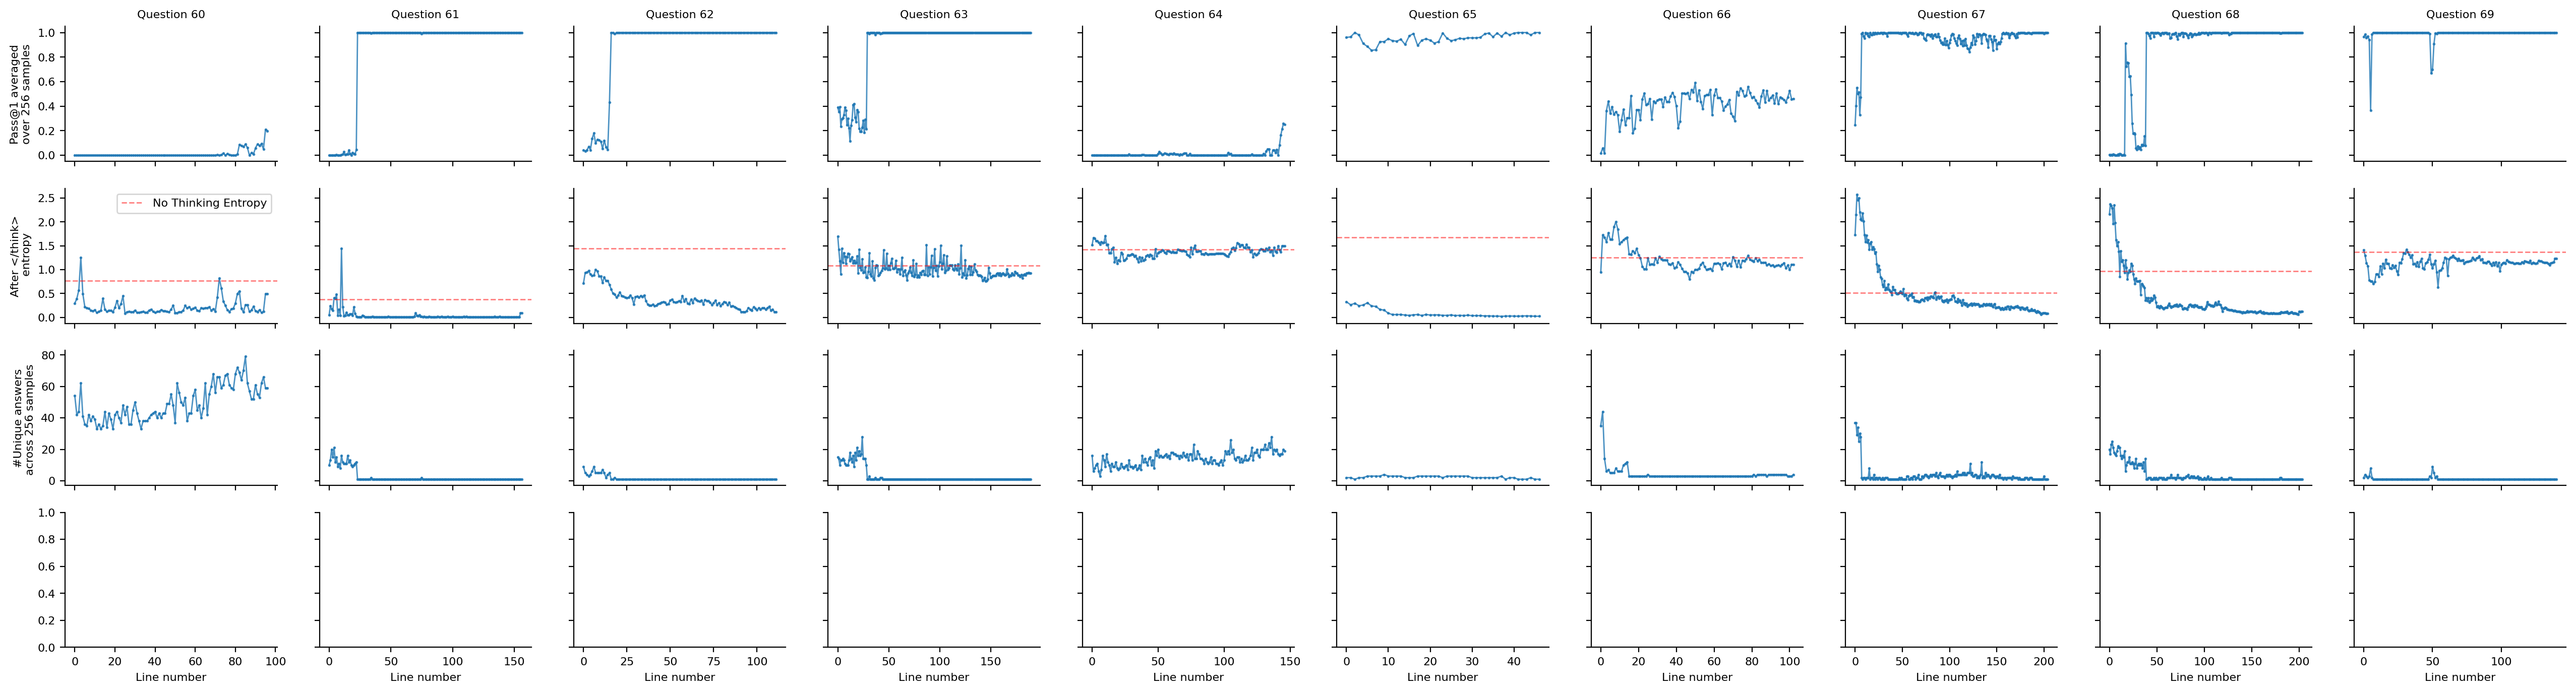

In [353]:
# batch_id = 15


for batch_id in range(7):

    fig, ax = plt.subplots(4, 10, figsize=(32, 8), sharex='col', sharey='row')
    line_config = {
        'linewidth': 1.0,
        'alpha': 0.8,
        'marker': 'o',
        'markersize': 1,
    }


    for i in range(10):
        ans, ua, acc, ent, no_thinking_entropy = load_log(batch_id * 10 + i)

        ax[2, i].plot(ua, **line_config)

        ax[0, i].plot(acc, **line_config)

        ax[1, i].plot(ent[:, 0], **line_config)

        ax[1, i].axhline(no_thinking_entropy, color='red', linestyle='--', label='No Thinking Entropy', linewidth=1.0, alpha=0.5)

    ax[1, 0].legend(fontsize=8)

    ax[0, 0].set_ylabel('Pass@1 averaged\nover 256 samples', fontsize=8)
    ax[1, 0].set_ylabel('After </think>\n entropy', fontsize=8)
    ax[2, 0].set_ylabel('#Unique answers\nacross 256 samples ', fontsize=8)

    for i, a in enumerate(ax.flatten()):
        if i < 10:
            a.set_title(f'Question {i + batch_id * 10}', fontsize=8)
            
        a.tick_params(axis='both', which='major', labelsize=8)
        # Hide frame
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)

    for a in ax[-1]:
        a.set_xlabel('Line number', fontsize=8)

    fig.savefig(f'/root/plots/results_batch_{batch_id}.pdf',  bbox_inches='tight')


FileNotFoundError: [Errno 2] No such file or directory: '/root/tts_and_entropy/outputs/plots/math_eval.pdf'

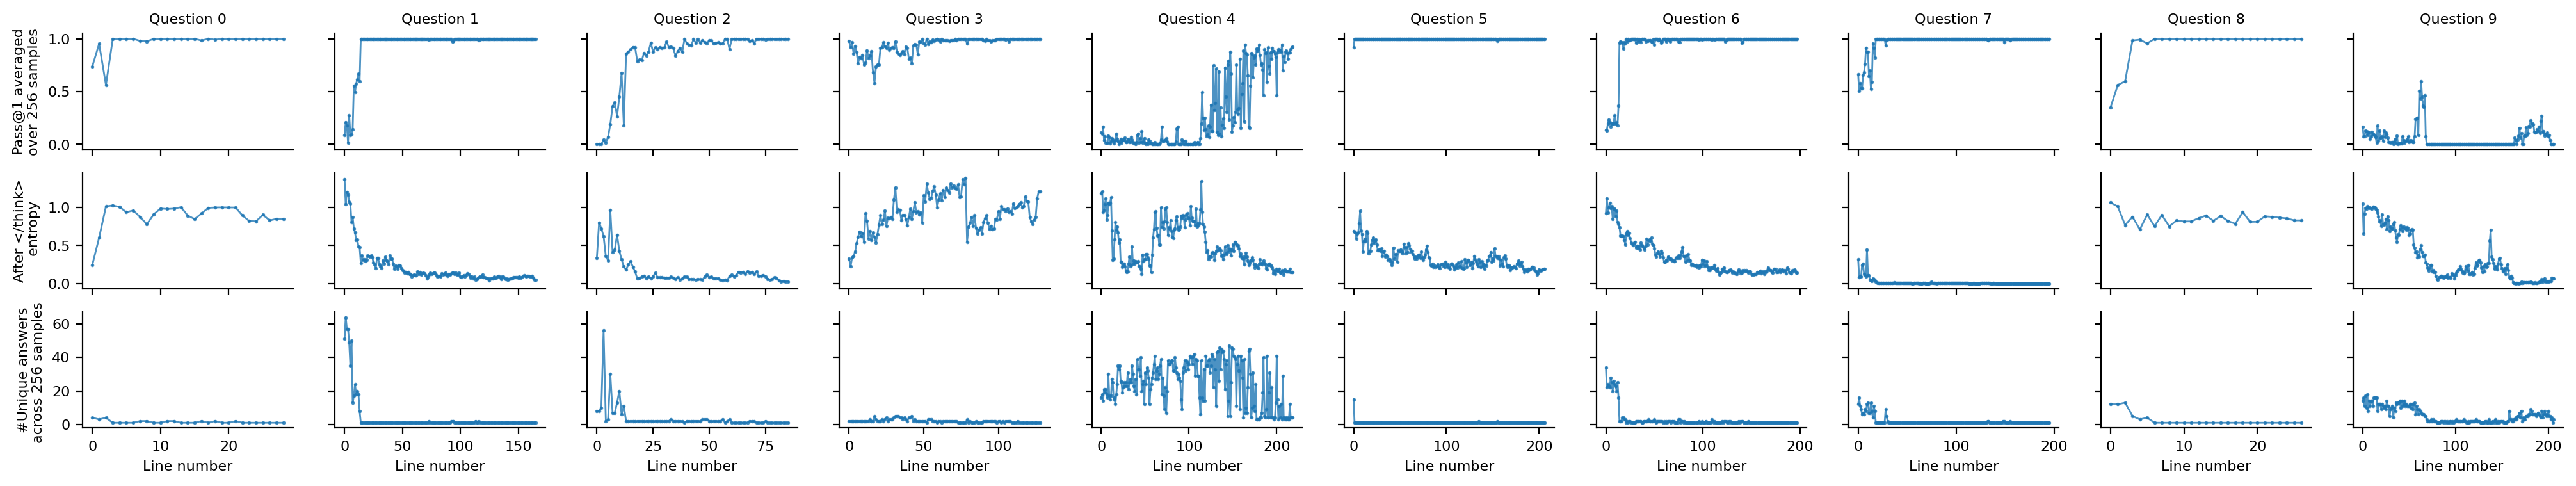

In [166]:
fig, ax = plt.subplots(3, 10, figsize=(25, 4), sharex='col', sharey='row')

line_config = {
    'linewidth': 1.0,
    'alpha': 0.8,
    'marker': 'o',
    'markersize': 1,
}

for i in range(10):
    ua = []
    for _A in all_extracted_answers[i]:
        ua.append(len(np.unique(_A)))
    ax[2, i].plot(ua, **line_config)


for i in range(10):
    ax[0, i].plot(load_log(i)[1], **line_config)
    log_dir = '/root/tts_and_entropy/outputs/entropy_log_math'
    file_name = f'entropy_{i}.npy'
    entropy = np.load(os.path.join(log_dir, file_name))
    ax[1, i].plot(entropy[:, 0], **line_config)

ax[0, 0].set_ylabel('Pass@1 averaged\nover 256 samples', fontsize=8)
ax[1, 0].set_ylabel('After </think>\n entropy', fontsize=8)
ax[2, 0].set_ylabel('#Unique answers\nacross 256 samples ', fontsize=8)

for i, a in enumerate(ax.flatten()):
    if i < 10:
        a.set_title(f'Question {i}', fontsize=8)
        
    a.tick_params(axis='both', which='major', labelsize=8)
    # Hide frame
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)

# ax[1, 0].set_yscale('log')

for a in ax[-1]:
    a.set_xlabel('Line number', fontsize=8)

fig.savefig('/root/tts_and_entropy/outputs/plots/math_eval.pdf',  bbox_inches='tight')
